This Jupyter notebook aims at deriving the possible climate impact reduction of different contrail mitigation strategies for hydrogen fuel cell powered aircrafts. It implements 3 cases:
- Case 1 : Water storage tank storing all the water that would otherwise produce frozen contrails aboard the aircraft and discharging when at the airport
- Case 2 : Water storage tank that stores the water in the ISSRs and that releases it when out of those ISSRs
- Case 3 : Water storage tank coupled to a release system under ISSR conditions to try to reach below the ISSR by dumping the water: water is expelled at the opposite speed to that of the aircraft.

It starts with a common functions definition that serves all parts. 

I: Common functions and parameters definition

In [5]:
import numpy as np
import matplotlib.pyplot as plt


In [6]:
#This nugget contains the main parameters for the ISSR

ISSR_max_vertical = 1 # km
ISSR_min_vertical = 0.1 # km

ISSR_max_horizontal = 400 # km
ISSR_min_horizontal = 1 # km

fuel_percentage_burnt_in_ISSR = np.linspace(0,1,100) #percentages in terms of plain numbers (e.g. : to enter 15 % write 0.15)


In [7]:
# This nugget presents the water production of the ATR 72-600 during the different phases of flight

water_prod_take_off = 299 # g/s of water
water_pro_cruise_landing = 192 # g/s

In [9]:
#definition of the 2 weather forecasts from which temperature is going to be interpolated. THIS TEMPERATURE IS IN °C
# PARAMETERS USED FOR NOTESBOOK TEST. Other parameters will be input later down the notebook for the real case studies.

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from zyGrib

cell_temp_bulletin1[0] = 11.2
cell_temp_bulletin1[1] =11.2
cell_temp_bulletin1[2] = 11
cell_temp_bulletin1[3] =11.8
cell_temp_bulletin1[4] = 11.8
cell_temp_bulletin1[5] =11.7
cell_temp_bulletin1[6] = 11.9
cell_temp_bulletin1[7] =12
cell_temp_bulletin1[8] = 11.8
cell_temp_bulletin1[9] =12.7
cell_temp_bulletin1[10] = 14.4
cell_temp_bulletin1[11] =13.8
cell_temp_bulletin1[12]= 13.3
cell_temp_bulletin1[13] =13.1
cell_temp_bulletin1[14] = 13.5
cell_temp_bulletin1[15] =13.8
cell_temp_bulletin1[16] = 14.1


cell_temp_bulletin2[0] = 16.5
cell_temp_bulletin2[1] =16.2
cell_temp_bulletin2[2] = 16
cell_temp_bulletin2[3] =18.1
cell_temp_bulletin2[4] = 18.5
cell_temp_bulletin2[5] =17.7
cell_temp_bulletin2[6] = 17.6
cell_temp_bulletin2[7] =17.7
cell_temp_bulletin2[8] = 19.7
cell_temp_bulletin2[9] =20.8
cell_temp_bulletin2[10] = 22.2
cell_temp_bulletin2[11] =22.5
cell_temp_bulletin2[12]= 20.8
cell_temp_bulletin2[13] =20.2
cell_temp_bulletin2[14] = 19.5
cell_temp_bulletin2[15] =19.3
cell_temp_bulletin2[16] = 18.8

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1026.5
cell_altitude_bulletin[1] = 1026.2
cell_altitude_bulletin[2] = 1025.8
cell_altitude_bulletin[3] = 1025.5
cell_altitude_bulletin[4] = 1024.9
cell_altitude_bulletin[5] = 1024.3
cell_altitude_bulletin[6] = 1023.8
cell_altitude_bulletin[7] = 1023.5
cell_altitude_bulletin[8] = 1023.3
cell_altitude_bulletin[9] = 1022.7
cell_altitude_bulletin[10] = 1022.3
cell_altitude_bulletin[11] = 1021.3
cell_altitude_bulletin[12]= 1021.2
cell_altitude_bulletin[13] =1021.2
cell_altitude_bulletin[14] =1021.1
cell_altitude_bulletin[15] = 1020.9
cell_altitude_bulletin[16] = 1020.8

In [10]:
# This function returns True if under the specified conditions contrails form, and False if they do not. It does not consider freezing but rather water vapour condensation in droplets.
# Freezing will be the point of another function. 

def contrail_appearance(T,P,e):

    

    R = 8.314 #SI, perfect gas constant
    L = 40700 #J/kg, water vaporisation enthalpy

    if not T < 293:
        #print("The temperature is not within the bounds of the formula validity, but it is anyway above 293 K so contrail or not it won't freeze and the climate impact can be neglected.")
        return False
    else:
        ea = e #in Pa
        Ta = T
        Tp = 363 #temperature of the exhaust plume in Kelvin
        ep = ea + (2/3)*P #partial water pressure of the plume.

## Determine which temperature equation is valid for the threshold considered
        G = (ep - ea)/(Tp - Ta) #in Pa/K
        if G > 2:
            Tmax = 226.031 + 10.2249*np.log(G) + 0.335372*(np.log(G))**2 + 0.0642105*(np.log(G))**3
        if G<=2 or T < 233:
            Tmax = 226.69 + 9.43*np.log(G-0.053) + 0.720*(np.log(G-0.053))**2

## Derive the thresholds temperatures
        e_star_Tmax = (G*R*Tmax**2)/L
        
        Tmin = Tmax - e_star_Tmax/G #in text to try sth else

        if T >= Tmax: 
            return False
        
        elif T <= Tmin:
            return True

## Use the criterion on relative humidity to determine if contrails form or not in the intermediate region
        elif Tmin < T < Tmax:
            e_star_T = e_star_Tmax*np.exp((L/R)*(1/Tmax - 1/T)) 
            RHmin = (e_star_Tmax-G*(Tmax-T))/e_star_T

            if e >= RHmin:
                return True
            else:
                return False

In [11]:
# This function allows for the computation of an ideal flightplan for the aircraft (in the absence of perturbations due to the atmosphere)

def alt(P): # P should be given in hPa. This function returns the altitude in m corresponding to the given P assuming the ISA and a P not too far away from sea level pressure.
    return 8.4*(1013.25-P)
    

# for now, an ideal flightplan will be assumed: take-off, then cruise at the ceiling (optimal cruise for the company), and then landing. d_flight should be provided in Nm. 
def flightplan_ideal(nb_point,bul_alt,d_flight):

    t_climb = (7600-alt(bul_alt[0]))/6.8834  # should be in s.
    t_desc = (7600-alt(bul_alt[-1]))/6.8834  # should be in s.
    V_ground_cl_ds = 87.18 #m/s, computed from the data presented in ModernAirliners. 
    V_cruise = 275 # kt
    t_flight = t_climb + t_desc + (d_flight/V_cruise)*3600 - (t_climb + t_desc)*V_ground_cl_ds/(V_cruise*0.5144)
    r_climb = 6.8834 # m/s


    t = np.linspace(0,t_flight,nb_point)
    flightplan = np.zeros(nb_point)

    for i in range(nb_point):

        if 0 < t[i] <= t_climb : 
            flightplan[i] = r_climb*t[i]

        elif t_climb < t[i] < t_flight - t_desc:
            flightplan[i] = 7600 # m , this is the ceiling of ATR-72-600

        elif t_flight - t_desc < t[i] < t_flight:
            flightplan[i] = 7600 - r_climb*(t[i]-(t_flight-t_desc))
    
    cell_climb = np.floor(nb_point*t_climb/t_flight)
    cell_desc = np.floor(nb_point*(t_flight-t_desc)/t_flight)

    nb_cells_not_cruise = cell_climb + (nb_point-1-cell_desc)

    d_parcel_cruise = (d_flight*1852 - (t_flight - t_desc + t_climb)*V_ground_cl_ds)/((nb_point - nb_cells_not_cruise))  ## this is the length of a parcel covered by the aircraft when in cruise, in m

    return [flightplan, t_flight/3600, nb_cells_not_cruise/nb_point, d_parcel_cruise] # the function retuns the flight altitude profile in m and the flight time in hours


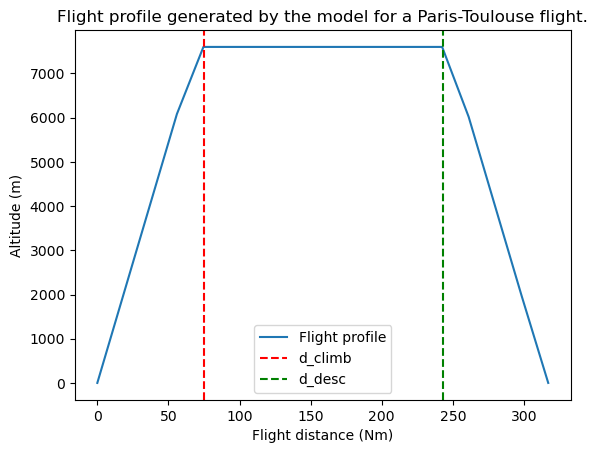

In [12]:
## plot for the thesis report

plan = flightplan_ideal(18, cell_altitude_bulletin, 317)[0]
percentage_cells_not_cruise = flightplan_ideal(18, cell_altitude_bulletin, 317)[2]

plt.figure()
abs = np.linspace(0,317,len(plan))
plt.plot(abs, plan, label = 'Flight profile')
plt.title("Flight profile generated by the model for a Paris-Toulouse flight.")
plt.xlabel("Flight distance (Nm)")
plt.ylabel("Altitude (m)")
plt.axvline(x = 75 , linestyle = "--", color = 'r', label = 'd_climb')
plt.axvline(x = 243 , linestyle = "--", color = 'g', label = 'd_desc')
plt.legend()

In [13]:
# This function determines is permanent contrails are generated along the flightpath of the aircraft.


def water_vapour_pressure(Pamb): # ATTENTION Pamb en hPa.

##############################################################################################  A REECRIRE  AVEC LA FONCTION SIGMOIDE ENVOYEE PAR ANTHONY ##################################################################
    # get the concentration from an approximation of the standard water vapour profile of the atmosphere in ppmv
    a = 17190
    xc = 62400
    k = 4.58*10**-5

    x = Pamb*100 ## Car Pamb est donné en hPa alors que la régression sigmoïde est faite pour une abscisse en Pa. 

    c = a*np.exp(-np.exp(-k*(x-xc)))  # the water vapour conventration in ppmv
    
    return c*Pamb*100/1000000 # to get the pressure out in Pa
    

def compute_standard_pressure(h): # returns the pressure in ISA at h in meters in Pa
    To = 288.16 #K
    g = 9.81 #SI
    M = 0.02897 #kg/mol
    Po = 101325 #Pa
    cp = 1004.68 #J/(kgK)
    R = 8.314

    return Po*(1-(g*h)/(cp*To))**(cp*M/R)



def permanent_contrail_proportion_on_route(bul1, bul2, bul_alt, flightplan, ISSR):
    ### useful data

    tflight = 1.289 # h
    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts
    nb_point = len(bul1)
    
    ### code 
    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,tflight, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for i in range(nb_point):
        cell_temp_ground[i] = bul1[i] + (bul2[i]-bul1[i])*X[i] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    ISA = cell_temp_sea - 15
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km

    
    # check for contrail formation
    formation = np.zeros(nb_point)

    for i in range (nb_point):
        T = cell_temp_alt[i] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[i]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[i] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    f = 0
    for x in formation:
        if x:
            f+=1
    
    # check for freezing

    freez = np.zeros(nb_point)
    for i in range(nb_point):
        if ISSR[i] and formation[i]:
            freez[i] = 1
    
    sum = 0
    for x in freez:
        sum += x


    print("Along this flight path under the specified ISSR conditions and assuming ISA temperature, water vapour and pressure profiles, the aircraft produced contrails over",100*f/nb_point ," % of its route and lasting cirrus contrails over ", 100*x/nb_point, " % of its route" )

    return 100*x/nb_point

def contrail_profile(bul1, bul2, bul_alt, flightplan):
    ### useful data

    tflight = flightplan[1] # h
    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts
    nb_point = len(bul1)
    
    ### code 
    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,tflight, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for i in range(nb_point):
        cell_temp_ground[i] = bul1[i] + (bul2[i]-bul1[i])*X[i] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    ISA = cell_temp_sea - 15
    cell_temp_alt = cell_temp_sea - 6.5*flightplan[0]/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km

    
    # check for contrail formation
    formation = np.zeros(nb_point)

    for i in range (nb_point):
        T = cell_temp_alt[i] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[0][i]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[i] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    f = 0
    for x in formation:
        if x:
            f+=1
    print("There is ", f*100/nb_point, " % of the flight producing contrails.\nThe contrail profile along the route is printed below and returned by this function.")
    print(formation)
    return formation

Text(0, 0.5, 'Typical water level (ppmv)')

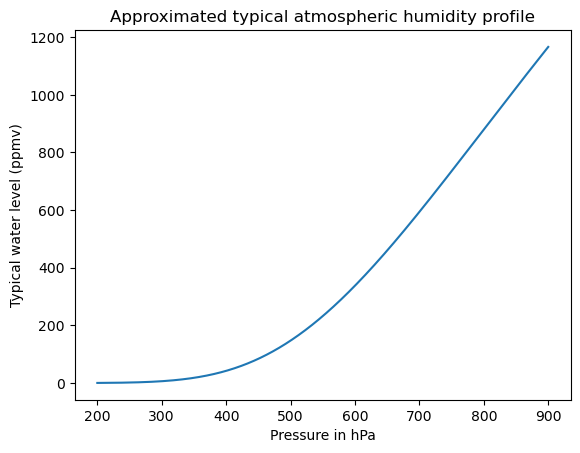

In [14]:
abs = np.linspace(200,900, 1000)
ord = np.zeros(len(abs))

for i in range(len(abs)):
    ord[i] = water_vapour_pressure(abs[i])

plt.figure()
plt.plot(abs, ord)
plt.title("Approximated typical atmospheric humidity profile")
plt.xlabel("Pressure in hPa")
plt.ylabel("Typical water level (ppmv)")

In [15]:
# This nuggest generates random ISSR along the route of the aircraft
# The following function returns an array of True and False correspondig to the length of the route, with a True when the point corresponds to an ISSR and a false when not
def random_ISSR_distrib(nb_point, percentage_along_route): # percentage given in plain number (ex : for 15 % enter 0.15)

    output = np.full(nb_point, False)
    distrib  = np.zeros(nb_point)

    for i in range(nb_point):
        distrib[i] = i
    
    considerate = nb_point*percentage_along_route


    squares_to_pick = int(np.ceil(considerate))
    squares_to_pick_hold = squares_to_pick
    picks = []


    li_distrib = []
    li_archive = []
    for x in distrib:
        li_distrib.append(x)
        li_archive.append(x)

    
    while squares_to_pick > 0:
        pick = np.random.choice(distrib, 1)[0]
        picks.append(pick)
        li_distrib.remove(pick)
        distrib = np.array(li_distrib)
        squares_to_pick-= 1

    for i in range(nb_point):
        for j in range(squares_to_pick_hold):

            if li_archive[i] == picks[j]:
                output[i] = True
            

    return output



II: Code for Case 1.
The only mitigation tool here is a water tank that stores the water in otherwise lasting contrails producing areas.

In [16]:
## Case 1 : store all the water produced onboard, optimal tank sizes for a Paris-Toulouse flight to mitigate 20%, 60%, 80% and 100% of emissions

def case1(bul1, bul2, bul_alt, flightplanification, date ="", filedate="", route="", path = ""): # Rq: flightime probably from the function flightplan so provided in hours

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]
    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)

    twenty = np.zeros(nb)
    fourty = np.zeros(nb)
    sixty = np.zeros(nb)
    eighty = np.zeros(nb)
    hundred = np.zeros(nb)
    
    for i in range(nb):
        
        ## part of permanent contrail proportion function code that is relevant to be used in my case

        tbulletin = 3 # h of difference between the two consecutive meteorological forecasts
        
        ### code 
        # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
        X = np.linspace(0,flighttime, nb_point)/tbulletin
        cell_temp_ground = np.zeros(nb_point)
        for g in range(nb_point):
            cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

        # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
        diff = (bul_alt-1013.25)*8.4 # meters
        cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
        cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km

        # check for contrail formation
        formation = np.zeros(nb_point)

        for j in range (nb_point):
            T = cell_temp_alt[j] + 273.15  # converted in Kelvin
            P = compute_standard_pressure(flightplan[j]) # in Pa
            e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
            formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 
        
        counter = 0 #number of points corresponding to a contrail that freezes
        ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])
        #print(ISSR)
        
        for k in range(nb_point):
            if formation[k]:
                if ISSR[k]:
                    counter += 1

        water_to_store = (counter/nb_point)*water_pro_cruise_landing*flighttime*3600/1000 # 0.01 bc the function returns a percentage in terms of 15 for 15 % instead of 0.15

        total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
        total_hydrogen_mass_consumed = total_water_mass_emitted/9

        water_to_store/=total_hydrogen_mass_consumed # the water mass to be stored is expressed in terms of the mass of the inital hydrogen fuel necessary for the flight. 
        # and /1000 to get the result in kg
        #print(water_to_store)
        #water_to_store = fuel_percentage_burnt_in_ISSR[i]*water_pro_cruise_landing*time_spot/1000

        twenty[i] = 0.2*water_to_store
        fourty[i] = 0.4*water_to_store
        sixty[i] = 0.6*water_to_store
        eighty[i] = 0.8*water_to_store
        hundred[i] = water_to_store

        
    one = np.ones(nb)

    fig ,ax = plt.subplots()
    
    plt.xlabel("Percentage of the flight distance spent in ISSR")
    plt.ylabel("Water mass (in multiples of initial fuel tank mass)") # The fuel considered here is hydrogen.
    title = "Mass of water to be stored onboard the aircraft to mitigate \n long-lasting cirrus contrail formation (Case 1)\nFlight: " + route +" (" + date + ")"
    plt.title(title)

    
    ax.plot(fuel_percentage_burnt_in_ISSR*100, twenty, color = 'r', label = '20% mitigation')
    ax.plot(fuel_percentage_burnt_in_ISSR*100, fourty, color = 'b', label = '40% mitigation')
    ax.plot(fuel_percentage_burnt_in_ISSR*100, sixty, color = 'g', label = '60% mitigation')
    ax.plot(fuel_percentage_burnt_in_ISSR*100, eighty, color = 'y', label = '80% mitigation')
    ax.plot(fuel_percentage_burnt_in_ISSR*100, hundred, color = 'k', label = '100% mitigation')
    ax.plot(fuel_percentage_burnt_in_ISSR*100, one, linestyle = 'dashed', label = 'mass of initial fuel tank')

    ax.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "--", color = 'r', label = 'Maximum ISSR percentage of the\n route attainable for this flight')

    ax.legend()
    ax.grid()
    ax.set_ylim(0,9)

    save_tag = path + "scenario1" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag,bbox_inches = 'tight')

## test of Case1 in the case of a Paris-Toulouse flight, i.e. 318 NM, 

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)
flightplan = flightdata[0]
flighttime = flightdata[1]

#case1(bul1, bul2, bul_alt, flightdata, date = "06/60/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")




III: Case 2.
Tests the following mitigation strategy:  store water onboard when crossing ISSRs and release it once out of those parcels of the route. The release rate of the water flowing out of the storage tank is here an important parameter, influencing standard deviation and mean results.

In [17]:
## Simple not averaged case.
## The variable release_rate represents the rate at which the tank of stored water empties itself.

def case2(bul1, bul2, bul_alt, flightplanification, release_rate): # Rq: flightime probably from the function flightplan so provided in hours, release_rate to be provided in g/s

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)

    ### ROUTE CONTRAIL ANALYSIS
    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts
        
    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km

    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 


    ### ROUTE FREEZING ANALYSIS AND WATER STORAGE NEEDS DERIVATION

    twenty = np.zeros(nb)
    fourty = np.zeros(nb)
    sixty = np.zeros(nb)
    eighty = np.zeros(nb)
    hundred = np.zeros(nb)
    
    for i in range(nb):
        
        ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])
        
        water_to_store = 0
        total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
        water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
        total_hydrogen_mass_consumed = total_water_mass_emitted/9 ## because H2 is 9 times lighter than H2O
        water_releasable_over_a_parcel = 3.6*release_rate*flighttime/nb_point  ## flighttime in hours so release_rate has to be converted from g/s to kg/h, by multiplying by 3.6
    
        for id in range(nb_point):
            if water_to_store < 0:
                print("water_to_store < 0 : error in code execution: ERROR")
                return False
            
            if formation[id]:
                if ISSR[id]:
                    water_to_store += water_produced_one_parcel
                else :## the only other option is not ISSR so water can be released
                    if water_to_store > water_releasable_over_a_parcel:
                        water_to_store -= water_releasable_over_a_parcel
                    else: 
                        water_to_store = 0

            else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                if water_to_store > water_releasable_over_a_parcel:
                    water_to_store -= water_releasable_over_a_parcel
                else: 
                    water_to_store = 0        

        
        #print(water_to_store)
        water_to_store/=total_hydrogen_mass_consumed # the water mass to be stored is expressed in terms of the mass of the inital hydrogen fuel necessary for the flight. 
        # and /1000 to get the result in kg
        

        twenty[i] = 0.2*water_to_store
        fourty[i] = 0.4*water_to_store
        sixty[i] = 0.6*water_to_store
        eighty[i] = 0.8*water_to_store
        hundred[i] = water_to_store

    one = np.ones(nb)

    plt.figure()
    plt.xlabel("Percentage of the flight distance spent in ISSR")
    plt.ylabel("Water mass (in multiples of initial fuel tank mass)") # The fuel considered here is hydrogen.
    plt.title("Mass of water to be stored onboard the aircraft to mitigate \n long-lasting cirrus contrail formation (Case 2)")

    plt.plot(fuel_percentage_burnt_in_ISSR*100, twenty, color = 'r', label = '20% mitigation')
    plt.plot(fuel_percentage_burnt_in_ISSR*100, fourty, color = 'b', label = '40% mitigation')
    plt.plot(fuel_percentage_burnt_in_ISSR*100, sixty, color = 'g', label = '60% mitigation')
    plt.plot(fuel_percentage_burnt_in_ISSR*100, eighty, color = 'y', label = '80% mitigation')
    plt.plot(fuel_percentage_burnt_in_ISSR*100, hundred, color = 'k', label = '100% mitigation')
    plt.plot(fuel_percentage_burnt_in_ISSR*100, one, linestyle = 'dashed', label = 'mass of initial fuel tank')

    plt.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "--", color = "r", label = 'Maximum ISSR percentage of the\n route attainable for this flight')

    plt.legend()

## test of Case1 in the case of a Paris-Toulouse flight, i.e. 318 NM, 

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)
release_rate = 192

#case2(bul1, bul2, bul_alt, flightdata, release_rate)

## Rq: for cruise and landing, water production rate = 192 g/s and for take-off, 299. Therefore, in non-ISSR, the water already flows out of the fuel cell in the atmosphere at the production rate, which is most of the time 192 g/s.
## It is therefore reasonable to assume for a first test a release rate equal to the production rate. (i.e. over a non-ISSR parcel, the water that is released from the tank equals the amount that would be stored in a ISSR parcel).


In [18]:
## Case2 shows an evolution similar to case1 but with more variations in the results coming from the random distribution of ISSR and with lower water storage requirements (as should be expected).
## The following code runs to do the same job as case1_average: extrapolate the average evolution of the curve.

def case2_average(bul1, bul2, bul_alt, flightplanification, nb_iter, release_rate, date ="", filedate="", route="", path = ""): #Rq: flightime in hours
    

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)
    

    twenty_av = np.zeros(nb)
    fourty_av = np.zeros(nb)
    sixty_av = np.zeros(nb)
    eighty_av = np.zeros(nb)
    hundred_av = np.zeros(nb)

    ## CONTRAIL FORMATION ANALYSIS


    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts

    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km


    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    total_hydrogen_mass_consumed = total_water_mass_emitted/9

    ## CONTRAIL FREEZING AND WATER REQUIREMENTS ANALYSIS
    ## now that we know where the contrails form along the track, we can implement a mean valkue that will smooth the edges of the curve of the previous function by averaging it on several iterations. 

    bank_twenty = []
    bank_fourty = []
    bank_sixty = []
    bank_eighty = []
    bank_hundred = []
    
    for ind in range(nb_iter):


        twenty = np.zeros(nb)
        fourty = np.zeros(nb)
        sixty = np.zeros(nb)
        eighty = np.zeros(nb)
        hundred = np.zeros(nb)
    
        for i in range(nb):
        
            ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])

            
            water_to_store = 0
            total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
            water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
            total_hydrogen_mass_consumed = total_water_mass_emitted/9 ## because H2 is 9 times lighter than H2O
            water_releasable_over_a_parcel = 3.6*release_rate*flighttime/nb_point  ## flighttime in hours so release_rate has to be converted from g/s to kg/h, by multiplying by 3.6

            maxi = 0
            for id in range(nb_point):
                if water_to_store < 0:
                    print("water_to_store < 0 : error in code execution: ERROR")
                    return False
            
                if formation[id]:
                    if ISSR[id]:
                        water_to_store += water_produced_one_parcel
                    else :## the only other option is not ISSR so water can be released
                        if water_to_store > water_releasable_over_a_parcel:
                            water_to_store -= water_releasable_over_a_parcel
                        else: 
                            water_to_store = 0

                else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                    if water_to_store > water_releasable_over_a_parcel:
                        water_to_store -= water_releasable_over_a_parcel
                    else: 
                        water_to_store = 0 
                
                if water_to_store > maxi:
                    maxi = water_to_store

            maxi/=total_hydrogen_mass_consumed # the water mass to be stored is expressed in terms of the mass of the inital hydrogen fuel necessary for the flight. 
        # and /1000 to get the result in kg
        
            

            twenty[i] = 0.2*maxi
            fourty[i] = 0.4*maxi
            sixty[i] = 0.6*maxi
            eighty[i] = 0.8*maxi
            hundred[i] = maxi
        
        bank_twenty.append(twenty)
        bank_fourty.append(fourty)
        bank_sixty.append(sixty)
        bank_eighty.append(eighty)
        bank_hundred.append(hundred)


        twenty_av=(twenty_av*ind + twenty)/(ind+1)
        fourty_av=(fourty_av*ind + fourty)/(ind+1)
        sixty_av=(sixty_av*ind + sixty)/(ind+1)
        eighty_av=(eighty_av*ind + eighty)/(ind+1)
        hundred_av=(hundred_av*ind + hundred)/(ind+1)


    error20 = np.zeros(nb)
    error40 = np.zeros(nb)
    error60 = np.zeros(nb)
    error80 = np.zeros(nb)
    error100 = np.zeros(nb)

    ## filling the dispersion errors into the lists.

    for ind_col in range(nb):
        var20 = 0
        var40 = 0
        var60 = 0
        var80 = 0
        var100 = 0

        for ind_row in range(nb_iter):
            var20 += ((bank_twenty[ind_row][ind_col]-twenty_av[ind_col])**2)/nb_iter
            var40 += ((bank_fourty[ind_row][ind_col]-fourty_av[ind_col])**2)/nb_iter
            var60 += ((bank_sixty[ind_row][ind_col]-sixty_av[ind_col])**2)/nb_iter
            var80 += ((bank_eighty[ind_row][ind_col]-eighty_av[ind_col])**2)/nb_iter
            var100 +=((bank_hundred[ind_row][ind_col]-hundred_av[ind_col])**2)/nb_iter


        error20[ind_col] = var20**0.5
        error40[ind_col] = var40**0.5
        error60[ind_col] = var60**0.5
        error80[ind_col] = var80**0.5
        error100[ind_col] = var100**0.5

        one = np.ones(nb)

    fig, ax = plt.subplots()

    plt.xlabel("Percentage of the flight distance spent in ISSR")
    plt.ylabel("Water mass (in multiples of initial fuel tank mass)") # The fuel considered here is hydrogen.
    title = "Mass of water to be stored onboard the aircraft to mitigate\nlong-lasting cirrus contrail formation (Case 2)\nRelease ratio = " + str(release_rate/192) + "\nFlight: " + route +" (" + date + ")"
    plt.title(title)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, twenty_av, color = 'r', label = '20% mitigation')
    #plt.errorbar(fuel_percentage_burnt_in_ISSR, twenty_av, yerr = error20, fmt = 'none', ecolor = 'r', capsize = 2)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, fourty_av, color = 'b', label = '40% mitigation')
    #plt.errorbar(fuel_percentage_burnt_in_ISSR, fourty_av, yerr = error40, fmt = 'none', ecolor = 'r', capsize = 2)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, sixty_av, color = 'g', label = '60% mitigation')
    #plt.errorbar(fuel_percentage_burnt_in_ISSR, sixty_av, yerr = error60, fmt = 'none', ecolor = 'r', capsize = 2)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, eighty_av, color = 'y', label = '80% mitigation')
    #plt.errorbar(fuel_percentage_burnt_in_ISSR, eighty_av, yerr = error80, fmt = 'none', ecolor = 'r', capsize = 2)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, hundred_av, color = 'k', label = '100% mitigation')
    ax.errorbar(fuel_percentage_burnt_in_ISSR*100, hundred_av, yerr = error100, fmt = 'none', ecolor = 'r', capsize = 2)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, one, linestyle = 'dashed', label = 'mass of initial fuel tank')


    ax.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "--", color = "r", label = 'Maximum ISSR percentage of the\n route attainable for this flight')

    plt.legend()
    plt.grid()
    ax.set_ylim(0,9)

    save_tag = path + "scenario2" +  "_" + route + "_" + filedate + "RR_" + str(release_rate/192) + ".png"
    plt.savefig(save_tag,bbox_inches = 'tight')

## test

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

release_rate = 192*100
#case2_average(bul1, bul2, bul_alt, flightdata, 1000, release_rate, date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

In [45]:
## this function studies the sensitivity of case2 average curve and standard deviation with respect to the tank water release rate

def case2_sensitivity(bul1, bul2, bul_alt, flightplanification, nb_iter, release_rates, date ="", filedate="", route="", path = ""): #Rq: flightime in hours
    

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)
    

    twenty_av = np.zeros(nb)
    fourty_av = np.zeros(nb)
    sixty_av = np.zeros(nb)
    eighty_av = np.zeros(nb)
    hundred_av = np.zeros(nb)

    ## CONTRAIL FORMATION ANALYSIS


    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts

    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km


    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    total_hydrogen_mass_consumed = total_water_mass_emitted/9

    ## CONTRAIL FREEZING AND WATER REQUIREMENTS ANALYSIS
    ## now that we know where the contrails form along the track, we can implement a mean valkue that will smooth the edges of the curve of the previous function by averaging it on several iterations. 

    bank_twenty = []
    bank_fourty = []
    bank_sixty = []
    bank_eighty = []
    bank_hundred = []
    
    error_stock = []
    mean_values_stock = []

    for ind_rate in range(len(release_rates)):

        release_rate = release_rates[ind_rate]


        for ind in range(nb_iter):


            twenty = np.zeros(nb)
            fourty = np.zeros(nb)
            sixty = np.zeros(nb)
            eighty = np.zeros(nb)
            hundred = np.zeros(nb)
    
            for i in range(nb):
        
                ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])

            
                water_to_store = 0
                total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
                water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
                total_hydrogen_mass_consumed = total_water_mass_emitted/9 ## because H2 is 9 times lighter than H2O
                water_releasable_over_a_parcel = 3.6*release_rate*flighttime/nb_point  ## flighttime in hours so release_rate has to be converted from g/s to kg/h, by multiplying by 3.6

                maxi = 0
                for id in range(nb_point):
                    if water_to_store < 0:
                        print("water_to_store < 0 : error in code execution: ERROR")
                        return False
            
                    if formation[id]:
                        if ISSR[id]:
                            water_to_store += water_produced_one_parcel
                        else :## the only other option is not ISSR so water can be released
                            if water_to_store > water_releasable_over_a_parcel:
                                water_to_store -= water_releasable_over_a_parcel
                            else: 
                                water_to_store = 0

                    else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                        if water_to_store > water_releasable_over_a_parcel:
                            water_to_store -= water_releasable_over_a_parcel
                        else: 
                            water_to_store = 0 

                    if water_to_store > maxi:
                        maxi = water_to_store

                maxi/=total_hydrogen_mass_consumed # the water mass to be stored is expressed in terms of the mass of the inital hydrogen fuel necessary for the flight. 
        # and /1000 to get the result in kg
        
            

                twenty[i] = 0.2*maxi
                fourty[i] = 0.4*maxi
                sixty[i] = 0.6*maxi
                eighty[i] = 0.8*maxi
                hundred[i] = maxi
        
            bank_twenty.append(twenty)
            bank_fourty.append(fourty)
            bank_sixty.append(sixty)
            bank_eighty.append(eighty)
            bank_hundred.append(hundred)


            twenty_av=(twenty_av*ind + twenty)/(ind+1)
            fourty_av=(fourty_av*ind + fourty)/(ind+1)
            sixty_av=(sixty_av*ind + sixty)/(ind+1)
            eighty_av=(eighty_av*ind + eighty)/(ind+1)
            hundred_av=(hundred_av*ind + hundred)/(ind+1)

        mean_values_stock.append(hundred_av)
        error20 = np.zeros(nb)
        error40 = np.zeros(nb)
        error60 = np.zeros(nb)
        error80 = np.zeros(nb)
        error100 = np.zeros(nb)

        error_stock.append(error100)
    ## filling the dispersion errors into the lists.

        for ind_col in range(nb):
            var20 = 0
            var40 = 0
            var60 = 0
            var80 = 0
            var100 = 0

            for ind_row in range(nb_iter):
                var20 += ((bank_twenty[ind_row][ind_col]-twenty_av[ind_col])**2)/nb_iter
                var40 += ((bank_fourty[ind_row][ind_col]-fourty_av[ind_col])**2)/nb_iter
                var60 += ((bank_sixty[ind_row][ind_col]-sixty_av[ind_col])**2)/nb_iter
                var80 += ((bank_eighty[ind_row][ind_col]-eighty_av[ind_col])**2)/nb_iter
                var100 +=((bank_hundred[ind_row][ind_col]-hundred_av[ind_col])**2)/nb_iter


            error20[ind_col] = var20**0.5
            error40[ind_col] = var40**0.5
            error60[ind_col] = var60**0.5
            error80[ind_col] = var80**0.5
            error100[ind_col] = var100**0.5

        

        

    Y, X = np.meshgrid(fuel_percentage_burnt_in_ISSR*100, release_rates/192)  #division byn 192 to get an adimensionned value
    
    error_stock = np.array(error_stock)

    def Z(X,Y):
        return error_stock
    
    values = Z(X,Y)

    constant_val = 100 - 100*percentage_cells_not_cruise
    delimitant = constant_val * np.ones(len(release_rates))

    levels = [0, 0.1, 0.3, 0.5, 0.7, 1, 3, 4, 5, 7, 9]
    level_bis = [0, 0.33, 0.66, 1, 1.33, 1.66, 2, 2.33, 2.66, 3]

    plt.subplot(122)

    plt.contourf(X,Y,values, level_bis)
    
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    plt.colorbar()
    plt.xlabel("Water tank release ratio")
    
    plt.title("Standard deviation\n(multiples of\ninitial fuel tank mass)")
    title = "Mass of water to be stored onboard the aircraft to mitigate \n long-lasting cirrus contrail formation\nFlight: " + route + "(" + date + ")"
    #plt.suptitle(title,fontweight = "bold",y=1.12)

    

    bank_hundred = np.array(bank_hundred)
    def foo(X,Y):
        return mean_values_stock
    
    foo_val = foo(X,Y)

    plt.subplot(121)
    CS = plt.contour(X, Y, foo_val, levels) #CS = ax.
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title("Value\n(multiples of\ninitial fuel tank mass)")
    plt.xlabel("Water tank release ratio")
    plt.ylabel("Percentage of the flight distance spent in ISSR")
    plt.grid()
    
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    
    save_tag = path + "scenario2_sensitivity" +  "_" + route + "_" + filedate + ".svg"
    plt.savefig(save_tag,bbox_inches = 'tight')

## test

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)


release_rate = 1536
release_rates = np.linspace(96, 1536, 100)
#case2_sensitivity(bul1, bul2, bul_alt, flightdata, 10, release_rates,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

In [20]:
def optimal_release(bul1, bul2, bul_alt, flightplanification): # Rq: flightime probably from the function flightplan so provided in hours, release_rate to be provided in g/s


    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]
    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)

    ### ROUTE CONTRAIL ANALYSIS
    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts
        
    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km

    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 


    ### ROUTE FREEZING ANALYSIS AND dATA STORAGE ABOUT HOW MUCH NEEDS TO BE STORED IN EACH ZONE

    # construction of a table that contains how much water that has to be stored is produced in each cell (element [i][j][0]) and that tells how many cells straight after a segment are available to empty the tank
    list_for_release = []
    for i in range(nb):
        info_ISSR = []
        ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])
        
        total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
        water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
        
    
        
        for id in range(nb_point):
            info_segment = []
            
            if formation[id]:
                if ISSR[id]:
                    info_segment.append(water_produced_one_parcel)
                else :## the only other option is not ISSR so water can be released
                    info_segment.append(0)

            else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                info_segment.append(0)   

            info_ISSR.append(info_segment)    
        list_for_release.append(info_ISSR)

    # now, list_for_release[i,j] represents the array of data about the route parcel j under the ISSR generated under the saturation percentage of conditions i
    ## ANALYSIS OF THE WATER STORAGE REQUIREMENTS IN TERMS OF THE FOLLOWING PARCELS

    for i in range(nb):
        for j in range(nb_point):
            counter = 0
            if j != nb_point-1:
            
                index = 1
                while (j + index < nb_point) and (list_for_release[i][j+index][0] == 0) : #there is no water to stock so the tank can be emptied on these ones
                    counter +=1 # determines the number of segments that can be used to release the water
                    index+=1
            list_for_release[i][j].append(counter)

    ## Maximum rate derivation for each flight under different ISSR distribution, the maximum being [i][j][0]/[i][j][1] : the amount of water to get rid of divided by the number of segments available for dumping. If there
    ## is 0 segment available for dumping, then the following is an ISSR and whatever water is left from the previous segment is added to the next one.
    result = []
    for i in range(nb):
        max = 0
        for j in range(nb_point):
            if j<nb_point-1 and list_for_release[i][j][1]==0: #then the next segment is still ISSR so the water that needs to be vented in j still is there in j+1
                list_for_release[i][j+1][0]+= list_for_release[i][j][0]
            elif j<nb_point-1 and list_for_release[i][j][0]/list_for_release[i][j][1] > max:
                max = list_for_release[i][j][0]/list_for_release[i][j][1]
        result.append(max)

    result = np.array(result)
    result = (nb_point/(3.6*flighttime)) * result ## conversion in g/s

    adimensioner = 192 # g/s, that is the water production rate from the fuel cell in cruise. This number allows to get a dimensionless number for the graph, as follows:
    result/=adimensioner

    plt.figure()
    plt.plot(fuel_percentage_burnt_in_ISSR*100, result)
    plt.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "--", color = "r", label = 'Maximum ISSR percentage of the\n route attainable for this flight')
    plt.title("Maximum required water tank release ratio over a non-ISSR route segment\nto always start the next ISSR zone empty")
    plt.xlabel("Percentage of the flight distance spent in ISSR")
    plt.ylabel("Water tank release ratio")
    plt.legend()
    plt.grid()


    return list_for_release

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#print(optimal_release(bul1,bul2,bul_alt, flightdata))

In [21]:
def optimal_release_averaged(bul1, bul2, bul_alt, flightplanification, nb_iter,date ="", filedate="", route="", path = ""): # Rq: flightime probably from the function flightplan so provided in hours, release_rate to be provided in g/s

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]
    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)

    ### ROUTE CONTRAIL ANALYSIS
    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts
        
    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km

    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 


    ### ROUTE FREEZING ANALYSIS AND dATA STORAGE ABOUT HOW MUCH NEEDS TO BE STORED IN EACH ZONE

    # construction of a table that contains how much water that has to be stored is produced in each cell (element [i][j][0]) and that tells how many cells straight after a segment are available to empty the tank

    result_av = np.zeros(nb)
    result_bank = [] # will serve to stock the data of each iteration to derive later the variance

    for big_ind in range(nb_iter):

        list_for_release = []
        for i in range(nb):
            info_ISSR = []
            ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])
        
            total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
            water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
            
        
            for id in range(nb_point):
                info_segment = []
            
                if formation[id]:
                    if ISSR[id]:
                        info_segment.append(water_produced_one_parcel)
                    else :## the only other option is not ISSR so water can be released
                        info_segment.append(0)

                else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                    info_segment.append(0)   

                info_ISSR.append(info_segment)    
            list_for_release.append(info_ISSR)

    # now, list_for_release[i,j] represents the array of data about the route parcel j under the ISSR generated under the saturation percentage of conditions i
    ## ANALYSIS OF THE WATER STORAGE REQUIREMENTS IN TERMS OF THE FOLLOWING PARCELS

        for i in range(nb):
            for j in range(nb_point):
                counter = 0
                if j != nb_point-1:
            
                    index = 1
                    while (j + index < nb_point) and (list_for_release[i][j+index][0] == 0) : #there is no water to stock so the tank can be emptied on these ones
                        counter +=1 # determines the number of segments that can be used to release the water
                        index+=1
                list_for_release[i][j].append(counter)

    ## Maximum rate derivation for each flight under different ISSR distribution, the maximum being [i][j][0]/[i][j][1] : the amount of water to get rid of divided by the number of segments available for dumping. If there
    ## is 0 segment available for dumping, then the following is an ISSR and whatever water is left from the previous segment is added to the next one.

        
        result = []
        for i in range(nb):
            max = 0
            for j in range(nb_point):
                if j<nb_point-1 and list_for_release[i][j][1]==0: #then the next segment is still ISSR so the water that needs to be vented in j still is there in j+1
                    list_for_release[i][j+1][0]+= list_for_release[i][j][0]
                elif j<nb_point-1 and list_for_release[i][j][0]/list_for_release[i][j][1] > max:
                    max = list_for_release[i][j][0]/list_for_release[i][j][1]
            result.append(max)
            

        result = np.array(result)
        result = (nb_point/(3.6*flighttime)) * result ## conversion in g/s

        adimensioner = 192 # g/s, that is the water production rate from the fuel cell in cruise. This number allows to get a dimensionless number for the graph, as follows:
        result/=adimensioner

        result_bank.append(result)

        result_av = (result_av*big_ind + result)/(big_ind+1)
        

    
## determination of the dispersion with the square root of the variance
    dispersion = np.zeros(nb)

    for ind_col in range(nb):
        var = 0
        mu = result_av[ind_col]

        for ind_row in range(nb_iter):
            var += (result_bank[ind_row][ind_col]-mu)**2

        var/= nb_iter
        dispersion[ind_col] = np.sqrt(var)

    

    error_values = dispersion

    one = np.ones(nb)

    fig, ax = plt.subplots()
    ax.plot(fuel_percentage_burnt_in_ISSR*100, one, linestyle = 'dashed', label = "Fuel cell water production rate during cruise")
    ax.plot(fuel_percentage_burnt_in_ISSR*100, result_av)
    ax.errorbar(fuel_percentage_burnt_in_ISSR*100, result_av, yerr = error_values, fmt = 'none', ecolor = 'r', capsize = 4)
    ax.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "--", color = "r", label = 'Maximum ISSR percentage of the\n route attainable for this flight')
    title = "Minimum required water tank release ratio over a non-ISSR route segment\nto always start the next ISSR zone empty\nFlight: " + route + "(" + date + ")"
    ax.set_title(title)
    ax.set_xlabel("Percentage of the flight distance spent in ISSR")
    ax.set_ylabel("Water tank release ratio")
    ax.legend()
    ax.grid()
    ax.set_ylim(0,15)
    save_tag = path + "scenario2_maximum_release_rate" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag, bbox_inches = 'tight')


bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#optimal_release_averaged(bul1,bul2,bul_alt, flightdata,100,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

IV: Case 3. 

The mitigation strategy is the following: there might be a small water tank storing some water onboard if necessary, but the main mitigation strategy is to have a releasing method of water within the ISSR. A big drop of water is pumped at a high pressure at a speed opposite to that of the aircraft and therefore "falls" straight away. It then breaks down into smaller droplets, that fall, evaporate and freeze. 
This part is thus broken down into two subparts: 
a) Study of the fall distance and derivation of orders of magnitude of the main parameters of height fall
b) implementation of the mitigation strategy using the parameters derived in a). 

a) Study of the falling water.

In [22]:
from scipy.integrate import odeint
from scipy.integrate import trapezoid


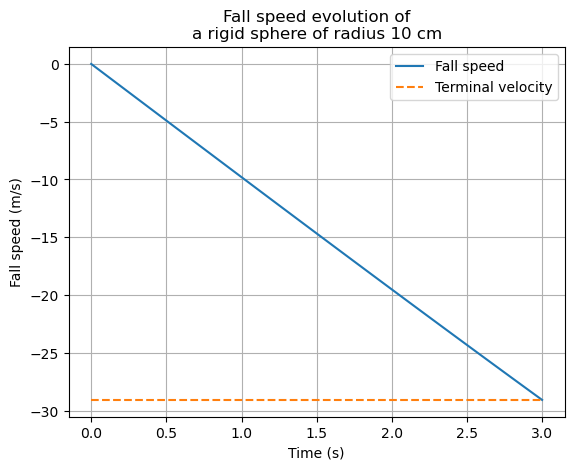

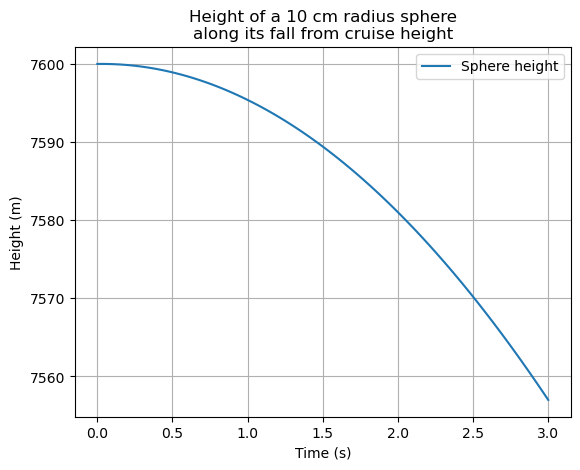

In [23]:
## solve for y..

g = 9.81
P0 = 101325 #Pa
M_air = 0.0289652 #g/mol
T0 = 288 #K
L = 0.0065 # K/m
R = 8.31446 # J/(mol.K)

def rho(z):
    
    val = (P0*M_air/(R*T0))*(1-(L*z)/T0)**((g*M_air)/(R*L)-1)

    return val

def Re(dens, V, l, mu):
    return dens*V*l/mu


radius = 0.1 # m
ro_air = 0.55 #0.9 
rho_water = 1000 # kg/m**3
S_cross = np.pi * radius**2 # m**2
m_drop = (4/3)*np.pi*radius**3*rho_water # m**3
Cd = 0.2 ## no dimension, but value to be confirmed


A = (0.5*ro_air*S_cross*Cd)/m_drop


def dy_dt(y, t):

    dydt = -g + A*y**2

    return dydt

# initial condition

y0 = 0

t = np.linspace(0,3,100)

# solving the differential equation for y. : 

y = odeint(dy_dt, y0, t)

# plot the results
v_term = y[-1]
term = v_term*np.ones(len(t))
plt.figure()
plt.plot(t, y,label = 'Fall speed')
plt.plot(t,term, label="Terminal velocity", linestyle = "--" )
plt.xlabel("Time (s)")
plt.ylabel("Fall speed (m/s)")
plt.title ("Fall speed evolution of\na rigid sphere of radius 10 cm")
plt.grid()
plt.legend()


## integration for y : the fall heigh in function of the time

height = np.zeros(len(t))
for time in range(len(t)):

    fun = np.zeros(time)

    for i in range(time):
        fun[i] = y[i]


    fall_height = trapezoid(fun,t[:time]) # m

    z0 = 7600 # m

    height[time] = z0 + fall_height

ground = np.zeros(len(t))

plt.figure()
plt.plot(t, height, label = 'Sphere height')
#plt.plot(t, ground, '--', label = "Ground")

plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("Height of a 10 cm radius sphere\nalong its fall from cruise height")
plt.legend()
plt.grid()

    #print("The height reached by the drop is : ", z0 + fall_height, " m")

0.550067942235235
0.8633915001209883


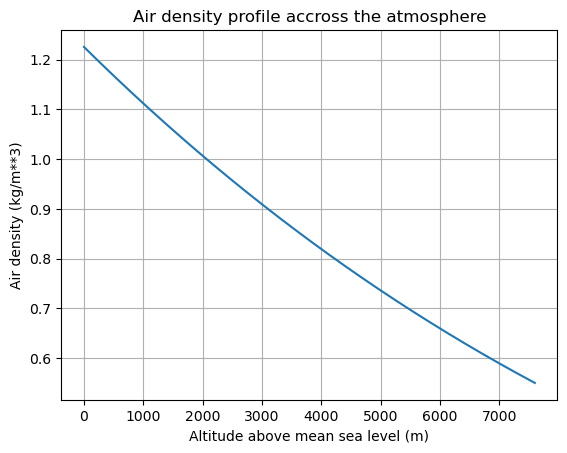

In [24]:
z = np.linspace (0, 7600, 1000)
densite = rho(z)

plt.plot(z, densite)
plt.xlabel("Altitude above mean sea level (m)")
plt.ylabel("Air density (kg/m**3)")
plt.title("Air density profile accross the atmosphere")
plt.grid()
print(rho(7600))
rho(7350)
print(rho(3500))

A first order of magnitude of the mass percentage of the drop evaporating while falling through the ISSR is 0.11706413997882076  %


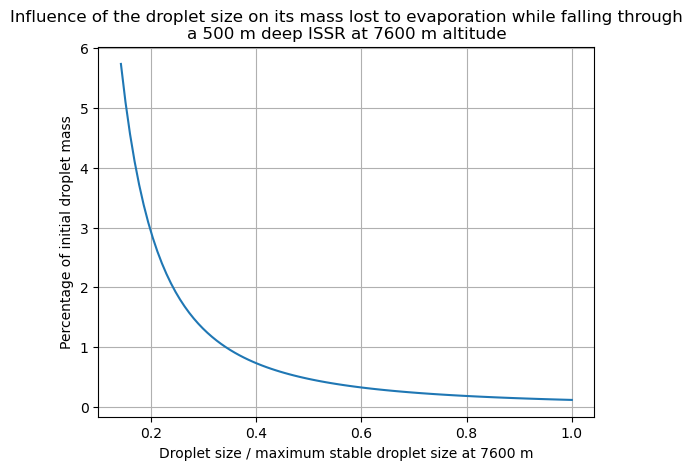

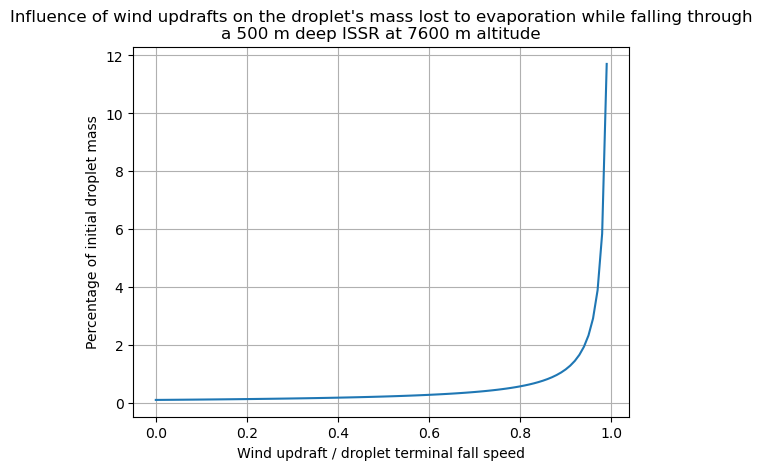

In [25]:
### This nugget aims at determining how much of the droplet evaporates during the fall out of the ISSR.
# From the article https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1256/qj.02.141?saml_referrer , ISSR vertical extent often seems to be about 500 m. Therefore, the values for evaluation here will be taken at the 
# mid-altitude of the zone, i.e. at 7350 m. 

r_eq = 0.0035 # m

v_t = 9 #13.52 # m/s, terminal fall velocity

w = 0 #m/s , vertical speed of the air mass (if positive, going down)

water_density = 1000 #kg/m3

R = 8.31 # SI, perfect gas constant

fv = 16.55 # fvmol parameter from the article, value in SI units

D = 1.84 * 10**(-5) # diffusivity coefficient of water vapour in air

M = 0.018 # kg/mol, molar mass of water

RH = 1.68  # relative humidity

Tair = 240.38 # K, air temperature

P1 = 42.31 # Pa, saturation pressure of water vapour at Tair

delta_T_drop = 0.815 # K

P2 = 39.59 # Pa, saturation pressure of water vapour at Tair - delta_T_drop

## Calulation of the first order of magnitude of the evaporation length assuming lambda = 1
factor = RH*P1/Tair - P2/(Tair - delta_T_drop)
L_evap = 500 # m
Lambd = 3*L_evap/(((r_eq**2) * (w + v_t) * water_density * R )/(fv * D * M * factor))

print("A first order of magnitude of the mass percentage of the drop evaporating while falling through the ISSR is", 100*Lambd , " %")


## study of the sensitivity of this evaporation to the size of the drop and to the strength of the wind updrafts

l_r_eq = np.linspace(0.0005, 0.0035, 100) # studying from the size 0 to the maximum stable raindrop size

l_w_up = np.linspace(-v_t*0.99, 0, 100) # studying from v_t to 0 (i.e. from the drop is stationary w.r.t. ground vs the drop is falling without any constrary wind)

stock_r = np.zeros(100)
stock_w = np.zeros(100)


for i in range(100):
    factor = RH*P1/Tair - P2/(Tair - delta_T_drop)
    L_evap = 500 # m
    stock_r[i] = 3*L_evap/(((l_r_eq[i]**2) * (w + v_t) * water_density * R )/(fv * D * M * factor))
    stock_w[i] = 3*L_evap/(((r_eq**2) * (l_w_up[i] + v_t) * water_density * R )/(fv * D * M * factor))

plt.figure()
plt.plot(l_r_eq/0.0035, stock_r*100)
plt.xlabel("Droplet size / maximum stable droplet size at 7600 m")
plt.ylabel("Percentage of initial droplet mass")
plt.title("Influence of the droplet size on its mass lost to evaporation while falling through\na 500 m deep ISSR at 7600 m altitude")
plt.grid()

plt.figure()
plt.plot(-l_w_up/v_t, stock_w*100)
plt.xlabel("Wind updraft / droplet terminal fall speed")
plt.ylabel("Percentage of initial droplet mass")
plt.title("Influence of wind updrafts on the droplet's mass lost to evaporation while falling through\na 500 m deep ISSR at 7600 m altitude")
plt.grid()


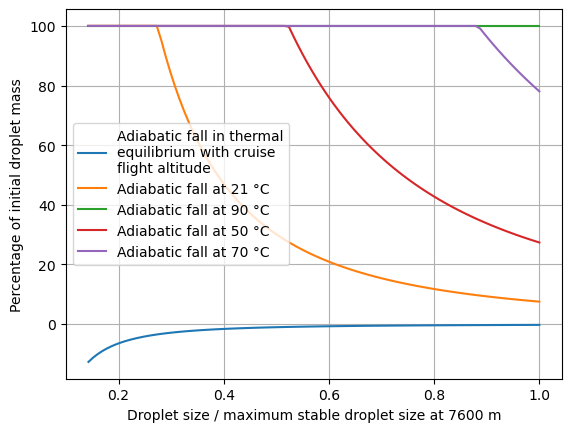

In [29]:
### This nugget aims at determining how much of the droplet evaporates during the fall out of the ISSR, and also studies the influence of temperature.
# From the article https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1256/qj.02.141?saml_referrer , ISSR vertical extent often seems to be about 500 m. Therefore, the values for evaluation here will be taken at the 
# mid-altitude of the zone, i.e. at 7350 m. 

r_eq = 0.0035 # m

v_t = -9 #13.52 # m/s, terminal fall velocity, must be negative in the lambda formula from the article.

w = 0 #m/s , vertical speed of the air mass (if positive, going down)

water_density = 1000 #kg/m3

R = 8.31 # SI, perfect gas constant

fv = 16.55 # fvmol parameter from the article, value in SI units

D = 1.84 * 10**(-5) # diffusivity coefficient of water vapour in air

M = 0.018 # kg/mol, molar mass of water

RH = 0.84*3  # relative humidity

Tair = 240.38 # K, air temperature

P1 = 42.31 # Pa, saturation pressure of water vapour at Tair

delta_T_drop1 = 1.63 # K for the drop in thermal equilibrium with its sourroundings

delta_T_drop2 = -53.77 #K for the drop in adiabatic fall at 20 °C

delta_T_drop3 = -122.77 #K for the drop in adiabatic fall at 80 °C

P2 = 37.05 # Pa, saturation pressure of water vapour at Tair - delta_T_drop

P3 = 2600 #Pa

P4 = 70000 #Pa

P5 = 10000 #Pa

P6 = 30000 #Pa
## Calulation of the first order of magnitude of the evaporation length assuming lambda = 1
#factor = RH*P1/Tair - P2/(Tair - delta_T_drop)
L_evap = 500 # m
#Lambd = 3*L_evap/(((r_eq**2) * (w + v_t) * water_density * R )/(fv * D * M * factor))

#print("A first order of magnitude of the mass percentage of the drop evaporating while falling through the ISSR is", 100*Lambd , " %")


## study of the sensitivity of this evaporation to the size of the drop and to the strength of the wind updrafts

l_r_eq = np.linspace(0.0005, 0.0035, 100) # studying from the size 0 to the maximum stable raindrop size

l_w_up = np.linspace(-v_t*0.99, 0, 100) # studying from v_t to 0 (i.e. from the drop is stationary w.r.t. ground vs the drop is falling without any constrary wind)



stock_r1 = np.zeros(100)
stock_w = np.zeros(100)
stock_r2 = np.zeros(100)
stock_r3 = np.zeros(100)
stock_r4 = np.zeros(100)
stock_r5 = np.zeros(100)

for i in range(100):
    factor1 = RH*P1/Tair - P2/(Tair - delta_T_drop1)
    factor2 = RH*P1/Tair - P3/(Tair - delta_T_drop2)
    factor3 = RH*P1/Tair - P4/(Tair - delta_T_drop3)
    factor4 = RH*P1/Tair - P5/323.15
    factor5 = RH*P1/Tair - P6/343.15
    L_evap = 500 # m
    stock_r1[i] = min(1,3*L_evap/(((l_r_eq[i]**2) * (w + v_t) * water_density * R )/(fv * D * M * factor1)))
    stock_r2[i] = min(1,3*L_evap/(((l_r_eq[i]**2) * (w + v_t) * water_density * R )/(fv * D * M * factor2)))
    stock_r3[i] = min(1,3*L_evap/(((l_r_eq[i]**2) * (w + v_t) * water_density * R )/(fv * D * M * factor3)))
    stock_r4[i] = min(1,3*L_evap/(((l_r_eq[i]**2) * (w + v_t) * water_density * R )/(fv * D * M * factor4)))
    stock_r5[i] = min(1,3*L_evap/(((l_r_eq[i]**2) * (w + v_t) * water_density * R )/(fv * D * M * factor5)))
    stock_w[i] = 3*L_evap/(((r_eq**2) * (l_w_up[i] + v_t) * water_density * R )/(fv * D * M * factor))

plt.figure()
plt.plot(l_r_eq/0.0035, stock_r1*100, label = 'Adiabatic fall in thermal\nequilibrium with cruise\nflight altitude')
plt.plot(l_r_eq/0.0035, stock_r2*100, label = 'Adiabatic fall at 21 °C')
plt.plot(l_r_eq/0.0035, stock_r3*100, label = 'Adiabatic fall at 90 °C')
plt.plot(l_r_eq/0.0035, stock_r4*100, label = 'Adiabatic fall at 50 °C')
plt.plot(l_r_eq/0.0035, stock_r5*100, label = 'Adiabatic fall at 70 °C')
plt.xlabel("Droplet size / maximum stable droplet size at 7600 m")
plt.ylabel("Percentage of initial droplet mass")
title = "Influence of the droplet size on its mass lost to evaporation while falling through\na 500 m deep ISSR at 7600 m altitude\nRH = " + str(100*RH) + " %"
#plt.title(title)
plt.grid()
plt.legend()

path = "RH = " + str(RH) + ".svg"
plt.savefig(path)

#plt.figure()
#plt.plot(-l_w_up/v_t, stock_w*100)
#plt.xlabel("Wind updraft / droplet terminal fall speed")
#plt.ylabel("Percentage of initial droplet mass")
#plt.title("Influence of wind updrafts on the droplet's mass lost to evaporation while falling through\na 500 m deep ISSR at 7600 m altitude")
#plt.grid()


Text(0.5, 1.0, 'Percentage of mass evaporation for a droplet to reach\na final temperature from an initial release temperature')

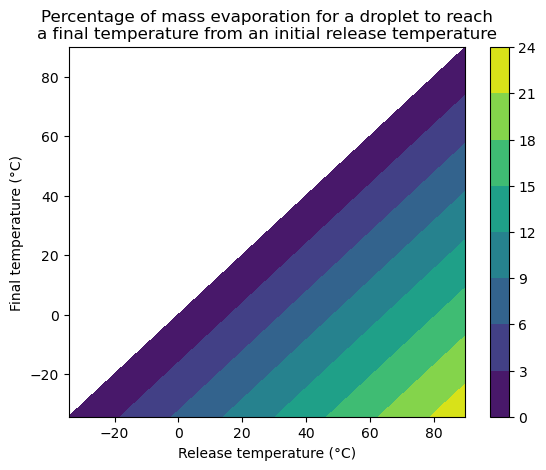

In [30]:
def Percentage_evap_droplet(T_init, T_final): 
    
    L_evap_wat = 40650 # J/mol
    cp_wat = 75.3 # J/(K.mol)

    delta_T_evap_tot = L_evap_wat/cp_wat # K : this is the temperature difference that is theoretically reached by evaporating the whole droplet 

    
    return (T_init-T_final)*100/delta_T_evap_tot

x = np.linspace(-34.4, 90)
y = x

Y,X = np.meshgrid(x,y)

Z = Percentage_evap_droplet(X,Y)

for i in range(len(Z)):
    for j in range(len(Z)):
        if Z[i][j] <0:
            Z[i][j] = -1

levels = [0,3,6,9,12,15,18,21,24]
plt.figure()
plt.contourf(X,Y,Z,levels)
plt.colorbar()
plt.xlabel("Release temperature (°C)")
plt.ylabel("Final temperature (°C)")
plt.title("Percentage of mass evaporation for a droplet to reach\na final temperature from an initial release temperature")


b) Implementation of the contrail mitigation model

As it seems likely that some droplets will reach below the ISSR, no storage seems to be necessary. The important data to retrieve is then
how much of the water needs to be pumped in ISSR zones (bc pumping = power = hydrogen burnt not for propulsion).



In [32]:
def case3_pumped_quantity(bul1, bul2, bul_alt, flightplanification, nb_iter,date ="", filedate="", route="", path = ""): 

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)

    ## CONTRAIL FORMATION ANALYSIS


    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts

    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km


    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    total_hydrogen_mass_consumed = total_water_mass_emitted/9


## WATER TO BE EXPELLED OUTSIDE ANALYSIS

    pump_bank = []

    pump_av = np.zeros(nb)

    for iter_index in range(nb_iter) : 

        pump_list = np.zeros(nb)

        for i in range(nb):
            ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])
            water_to_pump = 0
            pump_time = 0

            V_cruise = 275 #kt
            time_spent_in_a_parcel_in_cruise = flightdata[3]/(V_cruise*0.514)
            total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
            water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
            total_hydrogen_mass_consumed = total_water_mass_emitted/9 ## because H2 is 9 times lighter than H2O

            for id in range(nb_point):
            
                if formation[id] and ISSR[id]:
                    water_to_pump += water_produced_one_parcel
                    pump_time += time_spent_in_a_parcel_in_cruise

            water_to_pump/=total_hydrogen_mass_consumed # the water mass to be stored is expressed in terms of the mass of the inital hydrogen fuel necessary for the flight. 
            # and /1000 to get the result in kg
            pump_list[i] = water_to_pump

        pump_av = (iter_index*pump_av + pump_list)/(iter_index + 1)
        pump_bank.append(pump_list)


    error = np.zeros(nb)
    

    ## filling the dispersion errors into the lists.

    for ind_col in range(nb):
        var = 0

        for ind_row in range(nb_iter):
            var += ((pump_bank[ind_row][ind_col] - pump_av[ind_col])**2)/nb_iter

        error[ind_col] = var**0.5



    fig, ax = plt.subplots()
    ax.set_xlabel("Percentage of the flight distance spent in ISSR")
    ax.set_ylabel("Water mass (in multiples of initial fuel tank mass)") # The fuel considered here is hydrogen.
    title = "Water to be managed during the flight\nFlight: " + route + " (" + date + ") "
    ax.set_title(title)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, pump_av, label = 'Water producing long-lasting contrails')
    ax.plot(fuel_percentage_burnt_in_ISSR*100, np.ones(nb)*total_water_mass_emitted/total_hydrogen_mass_consumed, label = 'Total water production during the flight')

    no_cont = np.ones(nb)*total_water_mass_emitted/total_hydrogen_mass_consumed - pump_av

    ax.plot(fuel_percentage_burnt_in_ISSR*100, no_cont, label = 'Water not producing long-lasting contrails')
    
    

    one = np.ones(nb)
    ax.plot(fuel_percentage_burnt_in_ISSR*100, one, linestyle = 'dashed', label = 'Mass of initial fuel tank')
    ax.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "-.", color = "r", label = 'Maximum ISSR percentage of the\n route attainable for this flight')

    ax.legend()
    ax.grid()
    ax.set_ylim(0,10)
    save_tag = path + "scenario3_water_to_be_stored" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag)

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#case3_pumped_quantity(bul1, bul2, bul_alt, flightdata,10,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

V : Comparison of the costs of the different methods

This section aims at deriving for each mitigation method how much additional energy is consumed both in terms of initial fuel tank mass percentage and in equivalent passenger payload diminution.

In [33]:
### This function returns an array of the additional energy requirements in J for case 1 mitigation strategy with respect to the ISSR percentage


def case1_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification): # Rq: flightime probably from the function flightplan so provided in hours

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)

    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    
    
    

## part of permanent contrail proportion function code that is relevant to be used in my case

    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts
        
    ### code 
    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

        # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km

        # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here.     

## Increased energy requirements analysis

    energy_list = np.zeros(nb) ## contains the increased energy needs of the flights under different ISSR conditions. 
    glide_ratio = 17.5
    g = 9.81

    for i in range(nb):

        counter = 0 #number of points corresponding to a contrail that freezes
        water_in_tank = 0
        energy_use_during_flight = 0
        V_cruise = 275 # kt
        t_cell_cruise = flightdata[3]/(0.514*V_cruise)

        ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])

        
        
        for k in range(nb_point):
            water_in_tank = counter*water_pro_cruise_landing*t_cell_cruise/1000 # to get it in kg

            if formation[k]:
                if ISSR[k]:
                    counter += 1
                    water_in_tank += water_pro_cruise_landing*t_cell_cruise*0.5/1000 # some water will be produced along the route so the mean value is taken into acount on this parcel
            
            power_increase = water_in_tank*g/glide_ratio
            energy_cons_incr = power_increase*t_cell_cruise
            energy_use_during_flight+=energy_cons_incr
        
        energy_list[i] = energy_use_during_flight  ## in J

        mechanical_efficiency = 0.9
        FC_efficiency = 0.65 
        chemical_energy_list = energy_list/(FC_efficiency*mechanical_efficiency)


    return chemical_energy_list

## test of Case1 in the case of a Paris-Toulouse flight, i.e. 318 NM, 

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)
flightplan = flightdata[0]
flighttime = flightdata[1]


#print(case1_mitigation_energy_need(bul1, bul2, bul_alt, flightdata)/1000000)

In [34]:
### This function returns an array of the additional energy requirements in J for case 2 mitigation strategy with respect to the ISSR percentage, and an array of the standard deviation associated to the mean value result.


def case2_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, nb_iter, release_rate): #Rq: flightime in hours
    

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)
    
    energy_av = np.zeros(nb)

    ## CONTRAIL FORMATION ANALYSIS


    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts

    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km


    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    #print(formation)
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    total_hydrogen_mass_consumed = total_water_mass_emitted/9

    ## CONTRAIL FREEZING AND WATER REQUIREMENTS ANALYSIS
    ## now that we know where the contrails form along the track, we can implement a mean valkue that will smooth the edges of the curve of the previous function by averaging it on several iterations. 

    energy_bank = []
    
    glide_ratio = 17.5
    g = 9.81

    for ind in range(nb_iter):


        energy_list = np.zeros(nb) ## contains the increased energy needs of the flights under different ISSR conditions.
        
    
        for i in range(nb):
        
            ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])

            total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight

            #water_produced_one_parcel = water_pro_cruise_landing*flightdata[3]/(1000*0.514*275) ## to get it in kg
            water_produced_one_parcel = total_water_mass_emitted/nb_point

            water_releasable_over_a_parcel = 3.6*release_rate*flighttime/nb_point  ## flighttime in hours so release_rate has to be converted from g/s to kg/h, by multiplying by 3.6

            water_in_tank = 0
            energy_use_during_flight = 0
            V_cruise = 275 # kt
            #t_cell_cruise = flightdata[3]/(0.514*V_cruise)
            t_cell_cruise= flighttime*3600/nb_point

            water_in_tank_list = np.zeros(nb_point)

            for id in range(nb_point):
                if water_in_tank < 0:
                    print("water_in_tank < 0 : error in code execution: ERROR")
                    return False
            
                if formation[id]:
                    if ISSR[id]:
                        water_in_tank += water_produced_one_parcel
                        power_increase = V_cruise*0.514*(water_in_tank-0.5*water_produced_one_parcel)*g/glide_ratio  ## because we take the middle cell mass (at the beginning and the end of the cell the mass is not the same)
                        energy_cons_incr = power_increase*t_cell_cruise
                        energy_use_during_flight+=energy_cons_incr
                        

                    else :## the only other option is not ISSR so water can be released
                        if water_in_tank > water_releasable_over_a_parcel:
                            water_in_tank -= water_releasable_over_a_parcel
                            power_increase = V_cruise*0.514*(water_in_tank+0.5*water_releasable_over_a_parcel)*g/glide_ratio  ## because we take the middle cell mass (at the beginning and the end of the cell the mass is not the same)
                            energy_cons_incr = power_increase*t_cell_cruise
                            energy_use_during_flight+=energy_cons_incr
                        else: 
                            power_increase = V_cruise*0.514*(water_in_tank/2)*g/glide_ratio  ## because we take the middle cell mass (at the beginning and the end of the cell the mass is not the same)
                            energy_cons_incr = power_increase*t_cell_cruise
                            energy_use_during_flight+=energy_cons_incr
                            water_in_tank = 0 ## put at the end otherwise the initial value in this cell could not have been taken into account.


                else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                    if water_in_tank > water_releasable_over_a_parcel:
                        water_in_tank -= water_releasable_over_a_parcel
                        power_increase = V_cruise*0.514*(water_in_tank+0.5*water_releasable_over_a_parcel)*g/glide_ratio  ## because we take the middle cell mass (at the beginning and the end of the cell the mass is not the same)
                        energy_cons_incr = power_increase*t_cell_cruise
                        energy_use_during_flight+=energy_cons_incr
                    else: 
                        power_increase = V_cruise*0.514*(water_in_tank/2)*g/glide_ratio  ## because we take the middle cell mass (at the beginning and the end of the cell the mass is not the same)
                        energy_cons_incr = power_increase*t_cell_cruise
                        energy_use_during_flight+=energy_cons_incr
                        water_in_tank = 0 ## put at the end otherwise the initial value in this cell could not have been taken into account.

                water_in_tank_list[id] = water_in_tank
            
            

            energy_list[i] = energy_use_during_flight

            


        mechanical_efficiency = 0.9
        FC_efficiency = 0.65 
        chemical_energy_list = energy_list/(FC_efficiency*mechanical_efficiency)
        
        energy_bank.append(chemical_energy_list)

        energy_av = (energy_av*ind + chemical_energy_list)/(ind+1)


    error = np.zeros(nb)

    ## filling the dispersion errors into the lists.

    for ind_col in range(nb):
        var = 0

        for ind_row in range(nb_iter):
            var += ((energy_bank[ind_row][ind_col]-energy_av[ind_col])**2)/nb_iter
        
        error[ind_col] = var**0.5

    list_return = [energy_av, error]

    ## comparison with exact formula for case 1: 
    exact_1 = (total_water_mass_emitted*fuel_percentage_burnt_in_ISSR*g*0.514*V_cruise*(flighttime*3600))/(2*glide_ratio)
    exact_1/= (mechanical_efficiency*FC_efficiency)

    #print("The exact result for case 1 is: ", exact_1/1000000)
    

    #for i in range(1, len(fuel_percentage_burnt_in_ISSR)):
        #print(exact_1[i]/energy_av[i])

    return list_return

## test

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = cell_altitude_bulletinbul_alt = 1013.25 * np.ones(len(bul1))
flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

release_rate = 192*0
#print("heyyyp", case2_mitigation_energy_need(bul1, bul2, bul_alt, flightdata, 1000, release_rate)[0]/1000000)






In [36]:
### This function returns an array of the additional energy requirements in J for case 3 mitigation strategy with respect to the ISSR percentage.

def case3_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, nb_iter): 

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)

    ## CONTRAIL FORMATION ANALYSIS


    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts

    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km


    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    total_hydrogen_mass_consumed = total_water_mass_emitted/9


## WATER TO BE EXPELLED OUTSIDE ANALYSIS

    pump_bank = []
    eject_bank=[]
    cooling_HP_bank = []
    cooling_HE_bank = []
    cooling_H2_bank = []

    pump_av = np.zeros(nb)
    eject_av = np.zeros(nb)
    cooling_HP_av = np.zeros(nb)
    cooling_HE_av = np.zeros(nb)
    cooling_H2_av = np.zeros(nb)

    for iter_index in range(nb_iter):

        pump_list = np.zeros(nb)

        for i in range(nb):
        
            ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])

            water_to_pump = 0
            V_cruise = 275 #kt
            total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight

            #water_produced_one_parcel = water_pro_cruise_landing*flightplanification[3]/(1000*V_cruise*0.514) ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
            water_produced_one_parcel = total_water_mass_emitted/nb_point

            for id in range(nb_point):
            
                if formation[id] and ISSR[id]:
                    water_to_pump += water_produced_one_parcel
                
            pump_list[i] = water_to_pump

    
        ## additional fuel burn

        raw_energy_list = pump_list*0.5*(V_cruise*0.514)**2

        ## Diminution in fuel burn thanks to momentum effects
        m_aircraft = 23000 # kg, the MTOW
        r_drop = 0.0035 #m
        m_drop = 1000*(4/3)*np.pi*r_drop**3
        raw_ejection_energy = (m_drop/m_aircraft)*pump_list*4*(V_cruise*0.514)**2

        ## increase in consumption due to cooling drag

        T_goal = 21

        m_dot_wat = 192 #g/s
        cpm_water = 4185 #J/K/kg
        cpm_air = 1004 #J/K/kg
        T_ex = 90 # °C
        T_ext = -34.4 # °C
        T_cabin = 21 #°C
        L = 13.585 #m : half the wingspan of an ATR 72 600 bc the engines are in the middle and the exit at the back
        r = 0.002 #m radius use in the paper that gave the Cx
        Cx = 3 # found in https://onepetro.org/OTCONF/proceedings-abstract/83OTC/All-83OTC/49981 

        Q_to_exit = m_dot_wat*cpm_water*(T_ex-T_goal)*fuel_percentage_burnt_in_ISSR*flighttime*3600 ## the heat that needs to get out
        #print("The heat to be release equals this percentage of the heat requirements onbaord the aircrfaft: ", Q_to_exit/10000)

                # cooling drag for a heat pump
        COP = 2.9
        energ_HP = Q_to_exit/COP
                # cooling drag for a heat exchanger
        m_dot_air = m_dot_wat*(cpm_water/cpm_air)*((T_ex-T_goal)/(T_cabin-T_ext))
        Drag = 0.5*m_dot_air*V_cruise*0.514*2*np.pi*L*r*Cx
        energ_HE = Drag*0.514*V_cruise*flighttime*3600*fuel_percentage_burnt_in_ISSR

                # cooling using cryogenic hydrogen evaporation
        water_prod_rate = 192 #g/s
        H2_cons_rate = water_prod_rate/9000 # kg/s
        L_vap_H2 = 448000 #J/kg : https://www4.ac-nancy-metz.fr/physique/ancien_site/divers/liq-prop/Liq-prop.htm 
        necessary_H2_q_dot = L_vap_H2 * H2_cons_rate 
        necessary_H2_q = necessary_H2_q_dot*3600*flighttime
        energ_H2 = np.zeros(nb) ## energ_H2 represents the percentage of heat to be expelled that can be instead used onboard to prepare the hydrogen for entry in the fuel cell
        for i,x in enumerate(Q_to_exit/necessary_H2_q):
            energ_H2[i] = 100/x

        ## get the energy into fuel terms

        pump_efficiency = 0.7
        FC_efficiency = 0.65

        chemical_enegy_list = raw_energy_list/(pump_efficiency*FC_efficiency)
        chemical_ejection_energy = raw_ejection_energy/(pump_efficiency*FC_efficiency)
        chemical_energ_HE = energ_HE/(pump_efficiency*FC_efficiency)
        chemical_energ_HP = energ_HP/(FC_efficiency)
        chemical_energ_H2 = energ_H2

        ## compute the mean value and store for the standard deviation

        pump_av = (iter_index*pump_av + chemical_enegy_list)/(iter_index + 1)
        pump_bank.append(pump_list)

        eject_av = (iter_index*eject_av + chemical_ejection_energy)/(iter_index + 1)
        eject_bank.append(chemical_ejection_energy)

        cooling_HP_av = (iter_index*cooling_HP_av + chemical_energ_HP)/(iter_index + 1)
        cooling_HP_bank.append(chemical_energ_HP)

        cooling_HE_av = (iter_index*cooling_HE_av + chemical_energ_HE)/(iter_index + 1)
        cooling_HE_bank.append(chemical_energ_HE)

        cooling_H2_av = (iter_index*cooling_H2_av + chemical_energ_H2)/(iter_index + 1)
        cooling_H2_bank.append(chemical_energ_H2)

    error = np.zeros(nb)

    ## filling the dispersion errors into the lists.

    for ind_col in range(nb):
        var = 0

        for ind_row in range(nb_iter):
            var += ((pump_bank[ind_row][ind_col] - pump_av[ind_col])**2)/nb_iter

        error[ind_col] = var**0.5


    pump_efficiency = 0.7
    FC_efficiency = 0.65

    theoretical = fuel_percentage_burnt_in_ISSR*0.5*total_water_mass_emitted*(275*0.514)**2
    theoretical/=(1000000*0.7*0.65)
    #print(theoretical)
    

    to_return = [pump_av, error, eject_av, cooling_HP_av, cooling_HE_av, cooling_H2_av]

    return to_return




bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#res = case3_mitigation_energy_need(bul1, bul2, bul_alt, flightdata,1000)

In [37]:
## This function compares the energy requirements in terms of initial fuel tank for the three different methods

def energy_use_comp(bul1, bul2, bult_alt, flightplanification, date ="", filedate="", route="", path = ""):

    # declare useful variables
    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    percentage_cells_not_cruise = flightplanification[2]
    flighttime = flightplanification[1]

    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    fuel_tank_initial_mass = total_water_mass_emitted/9


    #load the different energy lists

    stock2 = case2_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, 100, 192*0)
    stock3 = case2_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, 100, 192*0.5)
    stock4 = case2_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, 100, 192*1)
    stock5 = case3_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, 100)
    

    L1 = case1_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification)
    L2 = stock2[0]
    L3 = stock3[0]
    L4 = stock4[0]
    L5 = stock5[0]
    L6 = stock5[3] # HP
    L7 = stock5[4] # HE

    err2 = stock2[1]
    err3 = stock3[1]
    err4 = stock4[1]
    err5 = stock5[1]

    H2_HHV = 39.39 # kWh / kg # The lower heating value is going to be used because (almost) no energy is recovered from the heat transmitted to the emitted water

    # get the lists in kWh, 1 kWh = 3.6*10**6 J
    L1/= (3.6*10**6)
    L2/= (3.6*10**6)
    L3/= (3.6*10**6)
    L4/= (3.6*10**6)
    L5/= (3.6*10**6)
    L6/= (3.6*10**6)
    L7/=(3.6*10**6)

    err2/=(3.6*10**6)
    err3/=(3.6*10**6)
    err4/=(3.6*10**6)
    err5/=(3.6*10**6)

    # get the equivalent hydrogen mass

    L1/=H2_HHV
    L2/=H2_HHV
    L3/=H2_HHV
    L4/=H2_HHV
    L5/=H2_HHV
    L6/=H2_HHV
    L7/=H2_HHV

    err2/=H2_HHV
    err3/=H2_HHV
    err4/=H2_HHV
    err5/=H2_HHV

    # get the equivalent percentage of the initial fuel tank


    L1/=fuel_tank_initial_mass
    L2/=fuel_tank_initial_mass
    L3/=fuel_tank_initial_mass
    L4/=fuel_tank_initial_mass
    L5/=fuel_tank_initial_mass
    L6/=fuel_tank_initial_mass
    L7/=fuel_tank_initial_mass


    err2/=fuel_tank_initial_mass
    err3/=fuel_tank_initial_mass
    err4/=fuel_tank_initial_mass
    err5/=fuel_tank_initial_mass

    
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Percentage of the flight distance spent in ISSR")
    ax.set_ylabel("Energy required/Total Fuel Energy initially on plane (%)")
    title = "Comparison of the energy requirements for contrail mitigation solutions\nFlight: " + route + " (" + date + ")"
    ax.set_title(title)
    

    ax.plot(fuel_percentage_burnt_in_ISSR*100, L2*100, label = 'Scenario 1')
    

    ax.plot(fuel_percentage_burnt_in_ISSR*100, L3*100, label = 'Scenario 2 with a 0.5 release ratio')
    ax.errorbar(fuel_percentage_burnt_in_ISSR*100, L3*100, yerr = err3*100, ecolor = 'g', fmt = 'none', capsize = 2)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, L4*100, label = 'Scneario 2 with an 8 release ratio')
    ax.errorbar(fuel_percentage_burnt_in_ISSR*100, L4*100, yerr = err4*100, ecolor = 'y', fmt = 'none', capsize = 2)

    ax.plot(fuel_percentage_burnt_in_ISSR*100, L5*100, label = 'Scenario 3 fuel')
    

    ax.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "-.", color = "r", label = 'Maximum ISSR percentage of the\n route attainable for this flight')

    ax.legend()
    ax.grid()
    ax.set_ylim(0,4)
    save_tag = path + "scenarii_comparison" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag, bbox_inches = 'tight')

    print("case2", L4*100)
    print("case 3", L5*100)

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#energy_use_comp(bul1, bul2, bul_alt, flightdata,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")


In [38]:
## This code draws a chart depending on the percentage of the flight spent in ISSR and the release rate of case 2 to determine under which conditions case 2 is cheaper than case 3. 

def energy_use_comp_sensitivity(bul1, bul2, bult_alt, flightplanification,date ="", filedate="", route="", path = ""):

    # declare useful variables
    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    percentage_cells_not_cruise = flightplanification[2]
    flighttime = flightplanification[1]

    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    fuel_tank_initial_mass = total_water_mass_emitted/9

    release_rate_mutliples = np.linspace(0,100,100)
    
    stock3 = case3_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, 100)[0]
    
    bank_plot = []

    for i in range(len(release_rate_mutliples)): 

        #load the different energy lists
        stock = case2_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, 100, 192*release_rate_mutliples[i])[0]
        
        comp = []

        for j in range(len(stock)):

            boolval = stock[j] > stock3[j] # l'énergie pour le cas 2 est supérieure à l'énergie pour le cas 3 

            if boolval : 
                comp.append(1) 
            else: 
                comp.append(0)

        bank_plot.append(comp)

        

    def Foo(X,Y):
        return bank_plot
    
    Y, X = np.meshgrid(fuel_percentage_burnt_in_ISSR*100, release_rate_mutliples)

    foo = Foo(X,Y)

    plt.figure()
    plt.contourf(X,Y,foo,1)
    title = "Comparison of the fuel costs of method 1 to method 3\n0: Case 2 less expensive than case 3\n1 : Case 2 more expensive than case 3\nFlight: " + route + " (" + date + ")"
    plt.title(title)
    plt.ylabel("Percentage of the route spent in ISSR")
    plt.xlabel("Tank release rate in multiple of cruise water production")

    plt.colorbar()
    x = 100 - 100*percentage_cells_not_cruise
    toplot = np.ones(len(release_rate_mutliples))*x
    plt.plot(release_rate_mutliples, toplot,linestyle = "-.", color = "r")
    save_tag = path + "scenarii_comparison_sensitivity" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag, bbox_inches = 'tight')


bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#energy_use_comp_sensitivity(bul1, bul2, bul_alt, flightdata,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")


In [39]:
## This function returns the cost of onboard storage methods in terms of paying passengers removal

def passenger_cost_volume(bul1, bul2, bul_alt, flightplanification, nb_iter,date ="", filedate="", route="", path = ""):
    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)
    

    twenty_av = np.zeros(nb)
    fourty_av = np.zeros(nb)
    sixty_av = np.zeros(nb)
    eighty_av = np.zeros(nb)
    hundred_av = np.zeros(nb)

    ## CONTRAIL FORMATION ANALYSIS


    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts

    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km


    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    total_hydrogen_mass_consumed = total_water_mass_emitted/9

    ## CONTRAIL FREEZING AND WATER REQUIREMENTS ANALYSIS
    ## now that we know where the contrails form along the track, we can implement a mean valkue that will smooth the edges of the curve of the previous function by averaging it on several iterations. 

    bank_twenty = []
    bank_fourty = []
    bank_sixty = []
    bank_eighty = []
    bank_hundred = []
    
    error_stock = []
    mean_values_stock = []

    for ind_rate in range(len(release_rates)):

        release_rate = release_rates[ind_rate]


        for ind in range(nb_iter):


            twenty = np.zeros(nb)
            fourty = np.zeros(nb)
            sixty = np.zeros(nb)
            eighty = np.zeros(nb)
            hundred = np.zeros(nb)
    
            for i in range(nb):
        
                ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])

            
                water_to_store = 0
                total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
                total_hydrogen_mass_consumed = total_water_mass_emitted/9
                water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
                water_releasable_over_a_parcel = 3.6*release_rate*flighttime/nb_point  ## flighttime in hours so release_rate has to be converted from g/s to kg/h, by multiplying by 3.6
                mass_of_water_for_a_passenger_volume = 1957 # kg or L

                maxi = 0
                for id in range(nb_point):
                    if water_to_store < 0:
                        print("water_to_store < 0 : error in code execution: ERROR")
                        return False
            
                    if formation[id]:
                        if ISSR[id]:
                            water_to_store += water_produced_one_parcel
                        else :## the only other option is not ISSR so water can be released
                            if water_to_store > water_releasable_over_a_parcel:
                                water_to_store -= water_releasable_over_a_parcel
                            else: 
                                water_to_store = 0

                    else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                        if water_to_store > water_releasable_over_a_parcel:
                            water_to_store -= water_releasable_over_a_parcel
                        else: 
                            water_to_store = 0 
                    if water_to_store > maxi:
                        maxi = water_to_store


                maxi/=mass_of_water_for_a_passenger_volume # the water mass to be stored is expressed in terms of the mass of the inital hydrogen fuel necessary for the flight. 
        # and /1000 to get the result in kg
        
                maxi*=(100/70)  ## to get the percentage of passengers rather than the number of passenger
            

                twenty[i] = 0.2*maxi
                fourty[i] = 0.4*maxi
                sixty[i] = 0.6*maxi
                eighty[i] = 0.8*maxi
                hundred[i] = maxi
        
            bank_twenty.append(twenty)
            bank_fourty.append(fourty)
            bank_sixty.append(sixty)
            bank_eighty.append(eighty)
            bank_hundred.append(hundred)


            twenty_av=(twenty_av*ind + twenty)/(ind+1)
            fourty_av=(fourty_av*ind + fourty)/(ind+1)
            sixty_av=(sixty_av*ind + sixty)/(ind+1)
            eighty_av=(eighty_av*ind + eighty)/(ind+1)
            hundred_av=(hundred_av*ind + hundred)/(ind+1)

        mean_values_stock.append(hundred_av)
        error20 = np.zeros(nb)
        error40 = np.zeros(nb)
        error60 = np.zeros(nb)
        error80 = np.zeros(nb)
        error100 = np.zeros(nb)

        error_stock.append(error100)
    ## filling the dispersion errors into the lists.

        for ind_col in range(nb):
            var20 = 0
            var40 = 0
            var60 = 0
            var80 = 0
            var100 = 0

            for ind_row in range(nb_iter):
                var20 += ((bank_twenty[ind_row][ind_col]-twenty_av[ind_col])**2)/nb_iter
                var40 += ((bank_fourty[ind_row][ind_col]-fourty_av[ind_col])**2)/nb_iter
                var60 += ((bank_sixty[ind_row][ind_col]-sixty_av[ind_col])**2)/nb_iter
                var80 += ((bank_eighty[ind_row][ind_col]-eighty_av[ind_col])**2)/nb_iter
                var100 +=((bank_hundred[ind_row][ind_col]-hundred_av[ind_col])**2)/nb_iter


            error20[ind_col] = var20**0.5
            error40[ind_col] = var40**0.5
            error60[ind_col] = var60**0.5
            error80[ind_col] = var80**0.5
            error100[ind_col] = var100**0.5

        

        

    Y, X = np.meshgrid(fuel_percentage_burnt_in_ISSR*100, release_rates/192)  #division byn 192 to get an adimensionned value
    
    error_stock = np.array(error_stock)

    def Z(X,Y):
        return error_stock
    
    values = Z(X,Y)

    constant_val = 100 - 100*percentage_cells_not_cruise
    delimitant = constant_val * np.ones(len(release_rates))

    levels_val = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05]
    levels_SD = [0, 0.05, 0.1, 0.15, 0.2,0.25, 0.3,0.35, 0.4]

    plt.subplot(122)
    plt.contourf(X,Y,values,levels_SD)
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    plt.colorbar()
    plt.xlabel("Water tank release ratio")
    plt.title("Standard deviation")


    bank_hundred = np.array(bank_hundred)
    def foo(X,Y):
        return mean_values_stock
    
    foo_val = foo(X,Y)

    
    plt.subplot(121)
    CS = plt.contour(X, Y, foo_val, levels_val)
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    plt.clabel(CS, inline=True, fontsize=10)
    title = "Percentage of the maximum number of passengers\ndisplaced by water storage\ndue to volume effects\nFlight: " + route + " (" + date + ")"
    plt.suptitle(title, y=1.1, fontweight = "bold")
    plt.title("Values")
    plt.xlabel("Water tank release ratio")
    plt.ylabel("Percentage of the flight distance spent in ISSR")
    save_tag = path + "passenger_cost_volume" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag, bbox_inches = 'tight')

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#passenger_cost_volume(bul1, bul2, bul_alt, flightdata, 10,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

In [40]:
# This function determines the percentage of passenger payload displaced if no increase in fuel consumption can be admitted by the airline: in other words, if the mass of the water to be stored is compensated by less passengers

def passenger_cost_mass(bul1, bul2, bul_alt, flightplanification, nb_iter,date ="", filedate="", route="", path = ""):
    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)
    

    twenty_av = np.zeros(nb)
    fourty_av = np.zeros(nb)
    sixty_av = np.zeros(nb)
    eighty_av = np.zeros(nb)
    hundred_av = np.zeros(nb)

    ## CONTRAIL FORMATION ANALYSIS


    tbulletin = 3 # h of difference between the two consecutive meteorological forecasts

    # get the temperature actually encountered by the aircraft's track as it flies above different places (account for time effect)
    X = np.linspace(0,flighttime, nb_point)/tbulletin
    cell_temp_ground = np.zeros(nb_point)
    for g in range(nb_point):
        cell_temp_ground[g] = bul1[g] + (bul2[g]-bul1[g])*X[g] #temperature encountered on the aircraft's route projection on the ground. still in °C

    # correct the temperature measured on the ground with the measure altitude and derive from this the ISA status of the point and the actual temperature at the aircraft flight altitude
    diff = (bul_alt-1013.25)*8.4 # meters
    cell_temp_sea = cell_temp_ground-6.5*diff/1000 #still in °C
    cell_temp_alt = cell_temp_sea - 6.5*flightplan/1000 #still in °C, division by 1000 bc flightplan altitude is given in meters and the gradient is -6.5 °C/km


    # check for contrail formation
    formation = np.zeros(nb_point)

    for j in range (nb_point):
        T = cell_temp_alt[j] + 273.15  # converted in Kelvin
        P = compute_standard_pressure(flightplan[j]) # in Pa
        e = water_vapour_pressure(P/100.0) # P/100 is in hPa for the function to work properly. e is out in Pa. 
        formation[j] = contrail_appearance(T,P,e) # all units should be fine arriving here. 

    
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 # all the water emitted along the flight
    total_hydrogen_mass_consumed = total_water_mass_emitted/9

    ## CONTRAIL FREEZING AND WATER REQUIREMENTS ANALYSIS
    ## now that we know where the contrails form along the track, we can implement a mean valkue that will smooth the edges of the curve of the previous function by averaging it on several iterations. 

    bank_twenty = []
    bank_fourty = []
    bank_sixty = []
    bank_eighty = []
    bank_hundred = []
    
    error_stock = []
    mean_values_stock = []

    for ind_rate in range(len(release_rates)):

        release_rate = release_rates[ind_rate]


        for ind in range(nb_iter):


            twenty = np.zeros(nb)
            fourty = np.zeros(nb)
            sixty = np.zeros(nb)
            eighty = np.zeros(nb)
            hundred = np.zeros(nb)
    
            for i in range(nb):
        
                ISSR = random_ISSR_distrib(nb_point,fuel_percentage_burnt_in_ISSR[i])

            
                water_to_store = 0
                total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
                total_hydrogen_mass_consumed = total_water_mass_emitted/9
                water_produced_one_parcel = total_water_mass_emitted/nb_point ## all the water produced by the aircraft along one meteorological distribution parcel of the flight. 
                water_releasable_over_a_parcel = 3.6*release_rate*flighttime/nb_point  ## flighttime in hours so release_rate has to be converted from g/s to kg/h, by multiplying by 3.6
                mass_of_water_for_a_passenger_mass = 82 # kg or L

                maxi  = 0
                for id in range(nb_point):
                    if water_to_store < 0:
                        print("water_to_store < 0 : error in code execution: ERROR")
                        return False
            
                    if formation[id]:
                        if ISSR[id]:
                            water_to_store += water_produced_one_parcel
                        else :## the only other option is not ISSR so water can be released
                            if water_to_store > water_releasable_over_a_parcel:
                                water_to_store -= water_releasable_over_a_parcel
                            else: 
                                water_to_store = 0

                    else: ## i.e. if there is no contrail formation on that zone at all, one does not care about being in an ISSR or not: water can be released. 
                        if water_to_store > water_releasable_over_a_parcel:
                            water_to_store -= water_releasable_over_a_parcel
                        else: 
                            water_to_store = 0 

                    if water_to_store > maxi:
                        maxi = water_to_store

                maxi/=mass_of_water_for_a_passenger_mass # the water mass to be stored is expressed in terms of the mass of the inital hydrogen fuel necessary for the flight. 
        # and /1000 to get the result in kg
        
                maxi*=(100/70)

                twenty[i] = 0.2*maxi
                fourty[i] = 0.4*maxi
                sixty[i] = 0.6*maxi
                eighty[i] = 0.8*maxi
                hundred[i] = maxi
        
            bank_twenty.append(twenty)
            bank_fourty.append(fourty)
            bank_sixty.append(sixty)
            bank_eighty.append(eighty)
            bank_hundred.append(hundred)


            twenty_av=(twenty_av*ind + twenty)/(ind+1)
            fourty_av=(fourty_av*ind + fourty)/(ind+1)
            sixty_av=(sixty_av*ind + sixty)/(ind+1)
            eighty_av=(eighty_av*ind + eighty)/(ind+1)
            hundred_av=(hundred_av*ind + hundred)/(ind+1)

        mean_values_stock.append(hundred_av)
        error20 = np.zeros(nb)
        error40 = np.zeros(nb)
        error60 = np.zeros(nb)
        error80 = np.zeros(nb)
        error100 = np.zeros(nb)

        error_stock.append(error100)
    ## filling the dispersion errors into the lists.

        for ind_col in range(nb):
            var20 = 0
            var40 = 0
            var60 = 0
            var80 = 0
            var100 = 0

            for ind_row in range(nb_iter):
                var20 += ((bank_twenty[ind_row][ind_col]-twenty_av[ind_col])**2)/nb_iter
                var40 += ((bank_fourty[ind_row][ind_col]-fourty_av[ind_col])**2)/nb_iter
                var60 += ((bank_sixty[ind_row][ind_col]-sixty_av[ind_col])**2)/nb_iter
                var80 += ((bank_eighty[ind_row][ind_col]-eighty_av[ind_col])**2)/nb_iter
                var100 +=((bank_hundred[ind_row][ind_col]-hundred_av[ind_col])**2)/nb_iter


            error20[ind_col] = var20**0.5
            error40[ind_col] = var40**0.5
            error60[ind_col] = var60**0.5
            error80[ind_col] = var80**0.5
            error100[ind_col] = var100**0.5

        

        

    Y, X = np.meshgrid(fuel_percentage_burnt_in_ISSR*100, release_rates/192)  #division byn 192 to get an adimensionned value
    
    error_stock = np.array(error_stock)

    def Z(X,Y):
        return error_stock
    
    values = Z(X,Y)

    constant_val = 100 - 100*percentage_cells_not_cruise
    delimitant = constant_val * np.ones(len(release_rates))

    level_val = [0,3,6,9,12,15,18,21,24,27]
    level_dev = [0,1,2,3,4,5,6,7,8,9,10]

    plt.subplot(122)
    plt.contourf(X,Y,values,level_dev)
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    plt.colorbar()
    plt.xlabel("Water tank release ratio")
    plt.title("Standard deviation")


    bank_hundred = np.array(bank_hundred)
    def foo(X,Y):
        return mean_values_stock
    
    foo_val = foo(X,Y)


    plt.subplot(121)
    CS = plt.contour(X, Y, foo_val, level_val)
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title("Values")
    plt.xlabel("Water tank release ratio")
    plt.ylabel("Percentage of the flight distance spent in ISSR")
    title = "Percentage of the maximum passenger payload\ndisplaced by water storage due to\nmass effects using Scenario 2\nFlight: " + route + " (" + date + ")"
    plt.suptitle(title, y=1.1, fontweight = "bold")

    save_tag = path + "passenger_cost_mass_strat_2" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag, bbox_inches = 'tight')
    
bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#passenger_cost_mass(bul1, bul2, bul_alt, flightdata, 10,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

In [41]:
# This function computes the amout of passengers that are displaced over a flight due to the use of mitigation strategy 3.

def passenger_cost_mass3(bul1, bul2, bul_alt, flightplanification, nb_iter,date ="", filedate="", route="", path = ""):

    flightplan = flightplanification[0]
    flighttime = flightplanification[1]
    percentage_cells_not_cruise = flightplanification[2]

    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)
    nb = len(fuel_percentage_burnt_in_ISSR)
    nb_point = len(bul1)
    
    stock = case3_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, nb_iter)
    energy = stock[0]
    err = stock[1]

    m_pass = 82 #kg
    f = 17
    g = 9.8 #m/s²
    V_cruise = 275*0.514 #m/s
    tflight = flighttime*3600 #s

    energy_one_person = m_pass*g*V_cruise*tflight/f
    nb_displaced = energy/energy_one_person
    perc_displaced = nb_displaced*100/72

    nb_err = err/energy_one_person
    perc_err = nb_err*100/70

    plt.figure()
    plt.plot(fuel_percentage_burnt_in_ISSR*100, perc_displaced)
    plt.xlabel("Percentage of the flight distance spent in ISSR")
    plt.ylabel("Percentage of maximum passenger payload")
    title = "Percentage of the maximum passenger payload\ndisplaced using Scenario 3\nFlight: " + route + " (" + date + ")"
    plt.axvline(x = 100 - 100*percentage_cells_not_cruise , linestyle = "-.", color = "r", label = 'Maximum ISSR percentage of the\n route attainable for this flight')
    plt.title(title)
    plt.grid()
    plt.legend()
    

    save_tag = path + "passenger_cost_mass_strat_3" +  "_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag, bbox_inches = 'tight')
    
bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 10,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

In [42]:
# This function returns the initial energy in the fuel tank in the form of hydrogen, in J, so that the aircraft completes its mission

def initial_energy_in_tank(flightplanification): #Rq: result in J. 
    
    LHV_H2 = 39.39 # kWh/kg

    flighttime = flightplanification[1]
    
    total_water_mass_emitted = water_pro_cruise_landing*flighttime*3600/1000 ## all the water produced by the fuel cell along the flight
    
    total_hydrogen_mass_consumed = total_water_mass_emitted/9 ## because H2 is 9 times lighter than H2O

    energy_necessary_to_mission = total_hydrogen_mass_consumed*LHV_H2*3.6*10**6  # mutiplication bc 1 kWh = 3.6*10**6

    return energy_necessary_to_mission
    
    
    
    
## test

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))

flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#initial_energy_in_tank(flightdata)/(3.6*10**6) ## affichage en MJ de kerosene

In [43]:
## This function calculates the break-even cost of hydrogen between methods 2 and 3. It is only a "beat version" of this idea and could not be 
# led to its term over the course of the thesis due to lack of reliable data and of time. The output results do therefore not make much sense.

def break_even(bul1, bul2, bul_alt, flightplanification, nb_iter,date ="", filedate="", route="", path = ""):

    LHV_H2 = 39.39 # kWh/kg
    V_cruise = 275 #kt
    m_passenger = 82 #kg
    g = 9.81 # m/s²
    f = 17.5 # the same one as the one of an A320
    t_flight = flightplanification[1]*3600

    percentage_cells_not_cruise = flightplanification[2]
    NRJ_per_passenger = m_passenger*g*V_cruise*0.514*t_flight/f # en J

    initial_energy_in_the_tank = initial_energy_in_tank(flightdata)


    stock2 = case2_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, nb_iter, 198*10)
    stock3 = case3_mitigation_energy_need(bul1, bul2, bul_alt, flightplanification, nb_iter)

    fuel2 = stock2[0] # energy required for Case 2 in J
    fuel3 = stock3[0] # energy required for Case 3 in J

    err2 = stock2[1]
    err3 = stock3[1]

    NRJ_sup = np.linspace(0,initial_energy_in_the_tank*0.125/100,100)

    cost_H2_breakeven = []
    
    fuel_percentage_burnt_in_ISSR = np.linspace(0,1,18)

    #computation of the value
    for i in range(len(NRJ_sup)):
        list_i=[]
        for j in range(len(fuel_percentage_burnt_in_ISSR)):
            if np.abs(fuel3[j] - fuel2[j]) > 1:
                C = (fuel2[j]-NRJ_sup[i])/(NRJ_per_passenger*(fuel3[j]/(LHV_H2*3.6*10**6)-fuel2[j]/(LHV_H2*3.6*10**6)))  ## cf formula established on manuscript 14 after kayak trip
                list_i.append(C)

            else : 
                list_i.append(0)
        cost_H2_breakeven.append(list_i)

    # computation of the standard deviation
    SD = []
    
    
    for i in range(len(NRJ_sup)):
        list_i=[]
        for j in range(len(fuel_percentage_burnt_in_ISSR)):
            sum_delta = err2[j] + err3[j]
            diff = (fuel3[j]-fuel2[j])*(1/(LHV_H2*3.6*10**6))
            if diff !=0:
                C = cost_H2_breakeven[i][j]*np.sqrt(((err2[j]/fuel2[j])**2) + ((sum_delta/diff)**2))
            else:
                C = 0
            list_i.append(np.abs(C))

        SD.append(list_i)

    def foo(X,Y):
        return cost_H2_breakeven

    def boo(X,Y):
        return SD

    Y, X = np.meshgrid(fuel_percentage_burnt_in_ISSR*100, NRJ_sup*100/initial_energy_in_the_tank)

    val = foo(X,Y)

    dev = boo(X,Y)

    constant_val = 100 - 100*percentage_cells_not_cruise
    delimitant = constant_val * np.ones(len(release_rates))

    level_val=[0,1,2,3, 4, 5, 6, 7,8]
    level_dev = [0,1,2,3,4,5,6]

    plt.subplot(121)
    plt.contourf(X,Y,val, 10)
    plt.colorbar()
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    plt.title("Value")
    plt.xlabel("Energy allocated to contrail mitigation\nin percentage of undisturbed\ninitial fuel tank.")
    plt.ylabel("Percentage of the route spent in ISSR")
    
    title = "Cost of hydrogen for Case 2 and 3 to break even\nin (£/kg)/(price of a passenger ticket in £)\nFlight: " + route + " (" + date + ")"
    plt.suptitle(title, y=1.05, fontweight = "bold")

    plt.subplot(122)
    plt.contourf(X,Y,dev,10)
    plt.plot(X, delimitant, linestyle = "--", color = "r", label = 'Maximum ISSR percentage\n attainable for this flight')
    plt.title("Standard deviation")
    plt.xlabel("Energy allocated to contrail mitigation\nin percentage of undisturbed\ninitial fuel tank.")
    plt.colorbar()

    save_tag = path + "break_even_" + route + "_" + filedate + ".png"
    plt.savefig(save_tag, bbox_inches = 'tight')
    

bul1 = cell_temp_bulletin1
bul2 = cell_temp_bulletin2
bul_alt = 1013.25 * np.ones(len(bul1))
flightdata = flightplan_ideal(len(bul1), bul_alt, 318)

#break_even(bul1, bul2, bul_alt, flightdata, 1,date = "06/06/2000", filedate = "06062000", route = "Paris-Toulouse", path = "hey/hoy/")

VI : ANALYSIS OF THE DIFFERENT ROUTES IN THE LIGHT OF THE FUNCTIONS ABOVE

In this section, all the analysis functions created in the nuggets above are used to analyze three routes: 
- Jakarta - Denpasar, an equatorial route
- Beijing - Shanghai, a mid-latitude route
- Longyearbyen - Mourmansk (not presented in the final thesis report because its results do not differ from the winter on Beijing-Shanghai)

Those three routes are studied on four dates each: 
- 21/03/2022 : spring equinox
- 21/06/2022 : summer solstice
- 21/09/2022 : autumn equinox
- 21/12/2022 : winter solstice

Some reults may bug and overlap on figures that should normally be different. If that happens when you try to generate the results, comment all the overlapping results but the one you are trying to generate. 

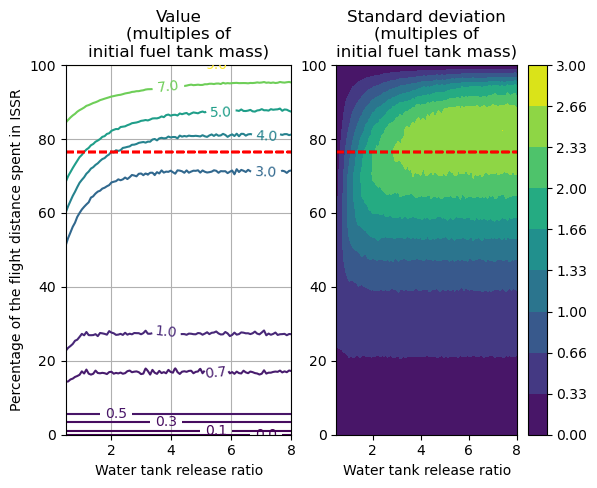

In [46]:
## Analysis for Beijing-Shanghai : 21/03/2022


nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 11.1
cell_temp_bulletin1[1] = 10.3
cell_temp_bulletin1[2] = 10
cell_temp_bulletin1[3] = 9.4
cell_temp_bulletin1[4] = 8.5
cell_temp_bulletin1[5] = 10
cell_temp_bulletin1[6] = 11.5
cell_temp_bulletin1[7] = 10
cell_temp_bulletin1[8] = 8.5
cell_temp_bulletin1[9] = 6.3
cell_temp_bulletin1[10] = 7.1
cell_temp_bulletin1[11] = 7.2
cell_temp_bulletin1[12] = 6.1
cell_temp_bulletin1[13] = 5
cell_temp_bulletin1[14] = 6.1
cell_temp_bulletin1[15] = 7.2
cell_temp_bulletin1[16] = 8.5


cell_temp_bulletin2[0] = 7.6
cell_temp_bulletin2[1] = 6
cell_temp_bulletin2[2] = 9.7
cell_temp_bulletin2[3] = 6.8
cell_temp_bulletin2[4] = 6.4
cell_temp_bulletin2[5] = 8.6
cell_temp_bulletin2[6] = 9.2
cell_temp_bulletin2[7] = 6.7
cell_temp_bulletin2[8] = 6.3
cell_temp_bulletin2[9] = 5.2
cell_temp_bulletin2[10] = 6.8
cell_temp_bulletin2[11] = 6.2
cell_temp_bulletin2[12]= 5.1
cell_temp_bulletin2[13] = 5
cell_temp_bulletin2[14] = 6.1
cell_temp_bulletin2[15] = 7.3
cell_temp_bulletin2[16] = 8.4

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis

#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/") # case 1


release_rate = 192*0.5
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/") # case 2 with a slow release rate


release_rate = 192*8
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/") # case 2 with a fast release rate


#optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/") # Study the optimal release rate


#case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/") # case 3


#energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/")


#passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/")


#passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/")


#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 100, date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/")

#passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/03/2022", filedate = "21032022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21032022/")


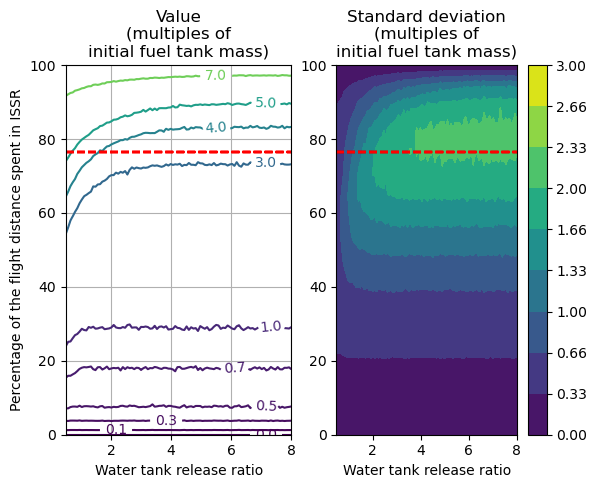

In [47]:
## Analysis for Beijing-Shanghai : 21/06/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 36.6
cell_temp_bulletin1[1] = 38.3
cell_temp_bulletin1[2] = 37.9
cell_temp_bulletin1[3] = 37.8
cell_temp_bulletin1[4] = 37.7
cell_temp_bulletin1[5] = 37.1
cell_temp_bulletin1[6] = 37.7
cell_temp_bulletin1[7] = 33.3
cell_temp_bulletin1[8] = 33.3
cell_temp_bulletin1[9] = 31.2
cell_temp_bulletin1[10] = 30.1
cell_temp_bulletin1[11] = 33.6
cell_temp_bulletin1[12] = 33.1
cell_temp_bulletin1[13] = 31.2
cell_temp_bulletin1[14] = 31.8
cell_temp_bulletin1[15] = 29.8
cell_temp_bulletin1[16] = 28.4


cell_temp_bulletin2[0] = 31.7
cell_temp_bulletin2[1] = 34.4
cell_temp_bulletin2[2] = 34.6
cell_temp_bulletin2[3] = 34.8
cell_temp_bulletin2[4] = 34.8
cell_temp_bulletin2[5] = 33.2
cell_temp_bulletin2[6] = 34.1
cell_temp_bulletin2[7] = 30
cell_temp_bulletin2[8] = 29.2
cell_temp_bulletin2[9] = 26.2
cell_temp_bulletin2[10] = 28.4
cell_temp_bulletin2[11] = 29.8
cell_temp_bulletin2[12]= 28
cell_temp_bulletin2[13] = 26.7
cell_temp_bulletin2[14] = 28.1
cell_temp_bulletin2[15] = 27
cell_temp_bulletin2[16] = 26.2

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/") # case 1

release_rate = 192*0.5
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/") # case 2 with a slow release rate

release_rate = 192*8
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/") # case 2 with a fast release rate

#optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/") # Study the optimal release rate

#case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/") # case 3

#energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/")

#passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/")

#passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/")

#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/")

#passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/06/2022", filedate = "21062022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21062022/")

C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2669382650.py:186: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\1853534507.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  energ_H2[i] = 100/x


case2 [0.         0.02277034 0.04781771 0.07754565 0.12055629 0.19152384
 0.25743132 0.36521092 0.47324352 0.65123166 0.91549408 1.18722011
 1.51992005 1.82744611 2.24199276 2.49891807 2.85388233 3.21314766]
case 3 [0.         0.00680352 0.0145087  0.02180404 0.02909938 0.0353291
 0.04377202 0.04975584 0.05729708 0.06606788 0.07196973 0.07959294
 0.08672434 0.09377377 0.10115107 0.1090202  0.11598766 0.12295511]


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2098070579.py:185: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


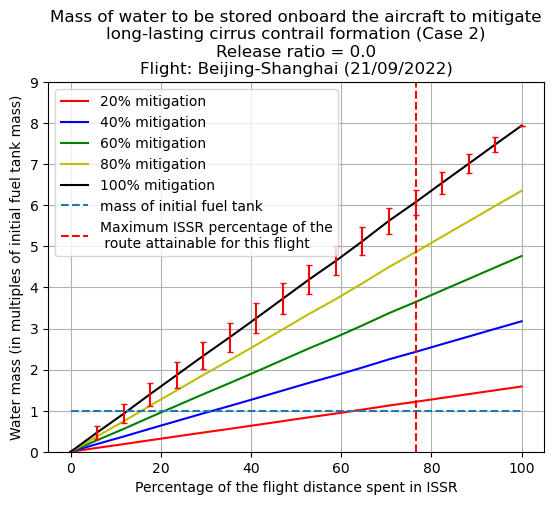

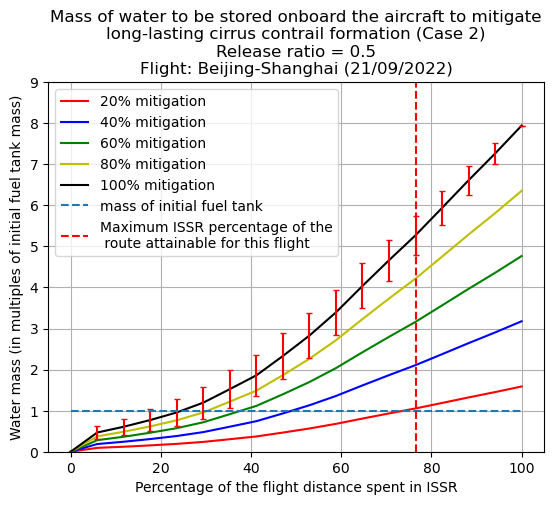

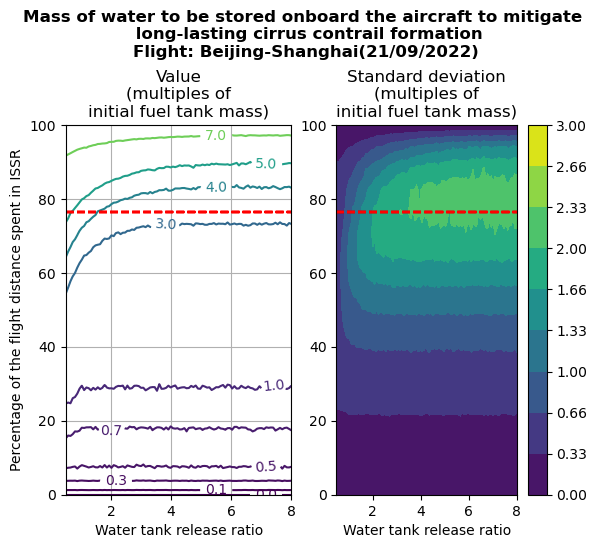

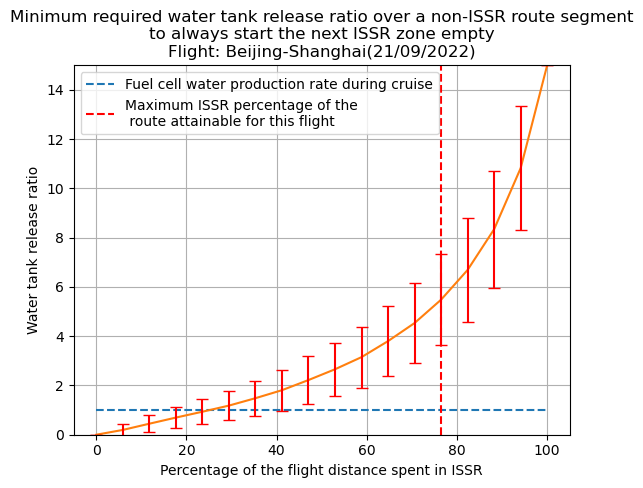

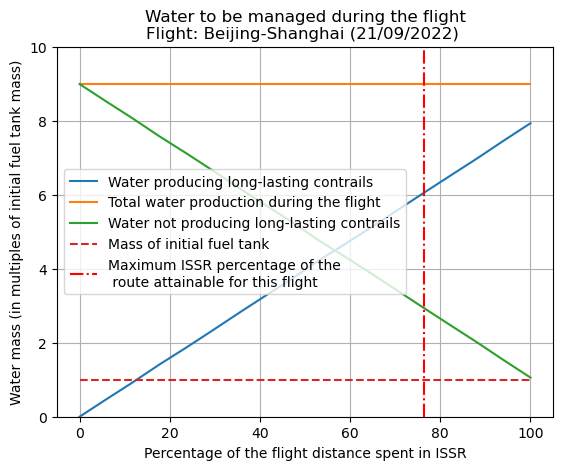

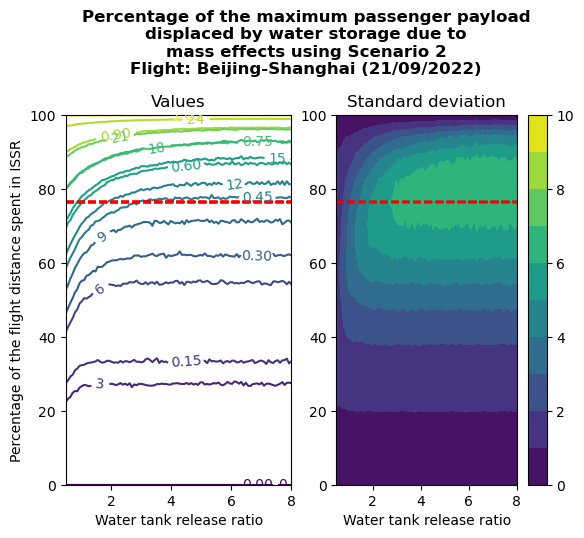

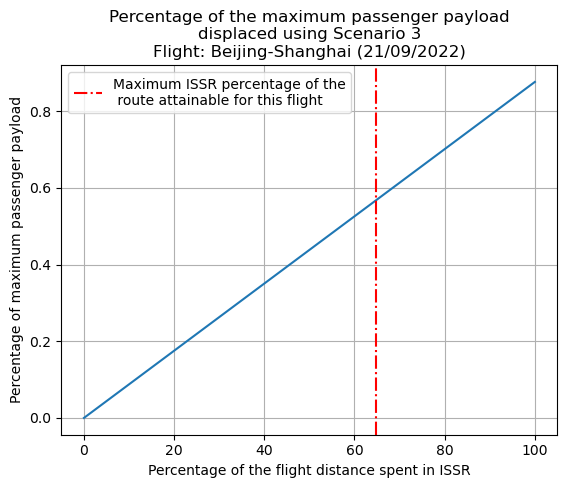

In [48]:
## Analysis for Beijing-Shanghai : 21/09/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 27.1
cell_temp_bulletin1[1] = 27.1
cell_temp_bulletin1[2] = 26.9
cell_temp_bulletin1[3] = 26.6
cell_temp_bulletin1[4] = 25.8
cell_temp_bulletin1[5] = 25.6
cell_temp_bulletin1[6] = 25.9
cell_temp_bulletin1[7] = 22.9
cell_temp_bulletin1[8] = 22.7
cell_temp_bulletin1[9] = 22.4
cell_temp_bulletin1[10] = 22.8
cell_temp_bulletin1[11] = 22.8
cell_temp_bulletin1[12]= 22
cell_temp_bulletin1[13] = 21.7
cell_temp_bulletin1[14] = 21.9
cell_temp_bulletin1[15] = 22.6
cell_temp_bulletin1[16] = 23.5


cell_temp_bulletin2[0] = 22.5
cell_temp_bulletin2[1] = 22.8
cell_temp_bulletin2[2] = 22.5
cell_temp_bulletin2[3] = 22
cell_temp_bulletin2[4] = 21.1
cell_temp_bulletin2[5] = 20.2
cell_temp_bulletin2[6] = 20.5
cell_temp_bulletin2[7] = 18.5
cell_temp_bulletin2[8] = 19.7
cell_temp_bulletin2[9] = 19.5
cell_temp_bulletin2[10] = 20.9
cell_temp_bulletin2[11] = 19.7
cell_temp_bulletin2[12]= 18.4
cell_temp_bulletin2[13] = 18.4
cell_temp_bulletin2[14] = 18.9
cell_temp_bulletin2[15] = 20.5
cell_temp_bulletin2[16] = 21.2

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/") # case 1

release_rate = 192*0.5
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/") # case 2 with a slow release rate

release_rate = 192*8
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/") # case 2 with a fast release rate

optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/") # Study the optimal release rate

case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/") # case 3

energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/")

passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/")

passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/")

#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/")

passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/09/2022", filedate = "21092022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21092022/")


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2669382650.py:186: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\1853534507.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  energ_H2[i] = 100/x


case2 [0.         0.02479437 0.05540782 0.08893082 0.13598952 0.20518604
 0.29892393 0.3772286  0.55546974 0.79177524 1.06919386 1.32940822
 1.73788278 2.1099248  2.45223888 2.86033393 3.23958655 3.65590423]
case 3 [0.         0.00819701 0.01639402 0.02459102 0.03278803 0.04098504
 0.04918205 0.05737905 0.06557606 0.07377307 0.08197008 0.09016708
 0.09836409 0.1065611  0.11475811 0.12295511 0.13115212 0.13934913]


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2098070579.py:185: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


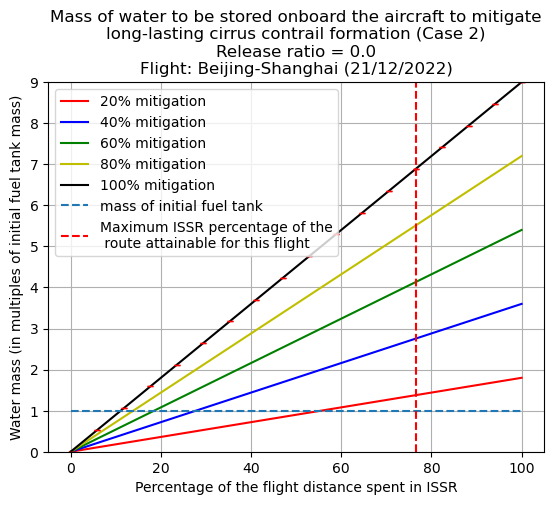

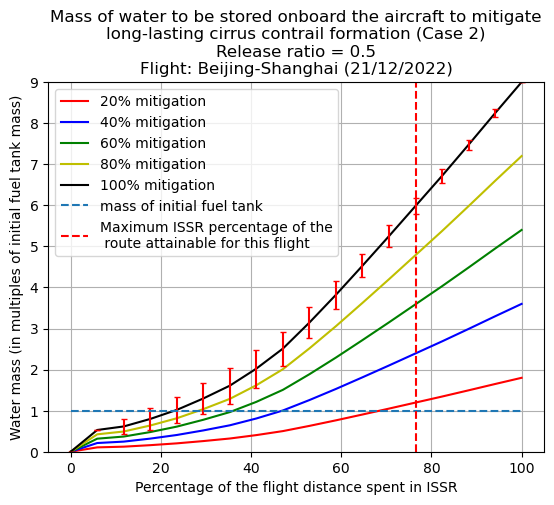

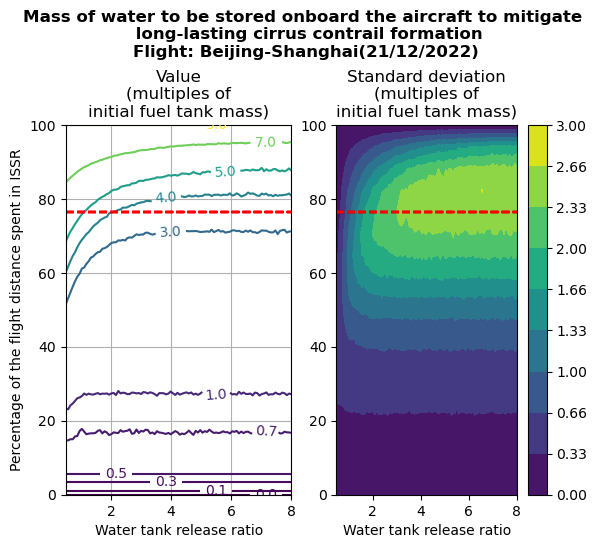

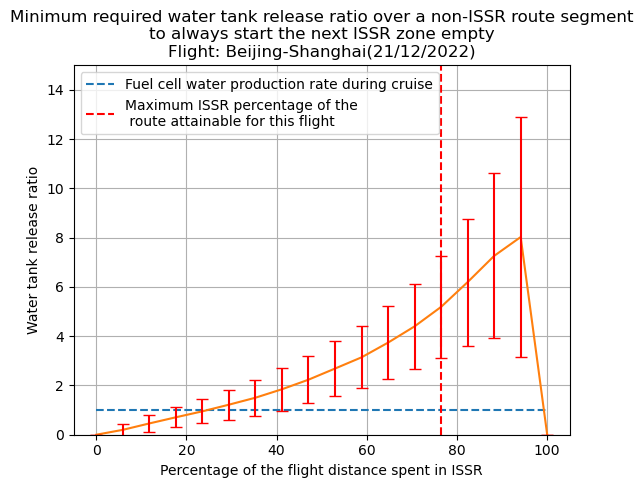

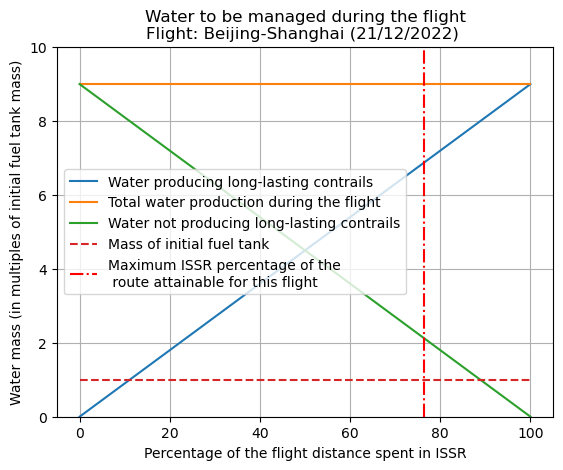

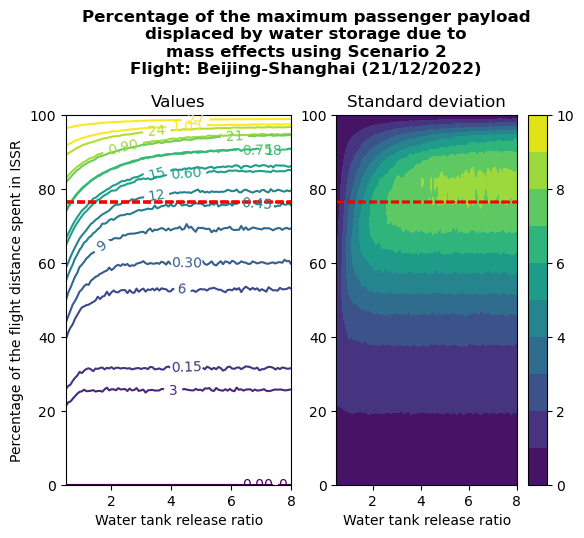

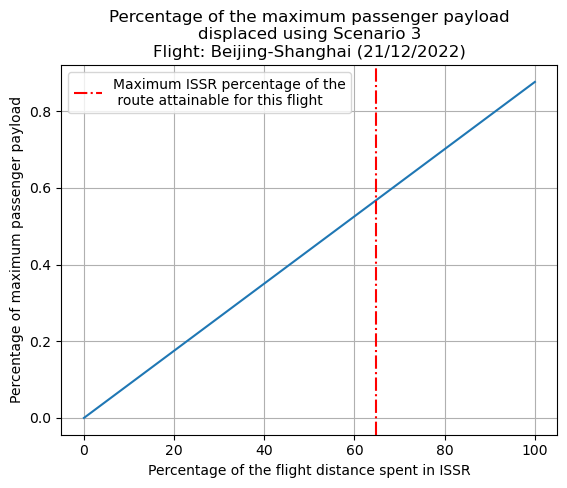

In [49]:
## Analysis for Beijing-Shanghai : 21/12/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = -2.4
cell_temp_bulletin1[1] = -1.7
cell_temp_bulletin1[2] = -0.9
cell_temp_bulletin1[3] = -0.6
cell_temp_bulletin1[4] = -0.3
cell_temp_bulletin1[5] = 0.5
cell_temp_bulletin1[6] = 1.2
cell_temp_bulletin1[7] = 0.2
cell_temp_bulletin1[8] = 1.7
cell_temp_bulletin1[9] = 2.3
cell_temp_bulletin1[10] = 4.3
cell_temp_bulletin1[11] = 5
cell_temp_bulletin1[12]= 6
cell_temp_bulletin1[13] = 6.9
cell_temp_bulletin1[14] = 7.8
cell_temp_bulletin1[15] = 8.5
cell_temp_bulletin1[16] = 9.7


cell_temp_bulletin2[0] = -2.9
cell_temp_bulletin2[1] = -2.1
cell_temp_bulletin2[2] = -2
cell_temp_bulletin2[3] = -2
cell_temp_bulletin2[4] = - 1.7
cell_temp_bulletin2[5] = -1.6
cell_temp_bulletin2[6] = -1.4
cell_temp_bulletin2[7] = -2.6
cell_temp_bulletin2[8] = -1.2
cell_temp_bulletin2[9] = -0.7
cell_temp_bulletin2[10] = 1.5
cell_temp_bulletin2[11] = 0.6
cell_temp_bulletin2[12]= 1.8
cell_temp_bulletin2[13] = 1.6
cell_temp_bulletin2[14] = 2.7
cell_temp_bulletin2[15] = 4.3
cell_temp_bulletin2[16] = 5.5

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/") # case 1

release_rate = 192*0.5
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/") # case 2 with a slow release rate

release_rate = 192*8
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/") # case 2 with a fast release rate

optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/") # Study the optimal release rate

case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/") # case 3

energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/")

passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/")

passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/")

#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/")

passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/12/2022", filedate = "21122022", route = "Beijing-Shanghai", path = "Graph_results/Beijing-Shanghai/21122022/")

C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2669382650.py:186: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\1853534507.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  energ_H2[i] = 100/x


case2 [0.         0.02201133 0.04882972 0.08488276 0.14067009 0.18304822
 0.25578679 0.37356004 0.50221245 0.63137087 0.88816967 1.24161592
 1.47475888 1.86362564 2.16988669 2.53307357 2.85400884 3.21314766]
case 3 [0.         0.00688549 0.01467264 0.02172207 0.02852559 0.03664062
 0.04385399 0.05000175 0.05713314 0.06467439 0.07311731 0.07926506
 0.08713419 0.09360983 0.10115107 0.10795459 0.11664342 0.12295511]


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2098070579.py:185: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


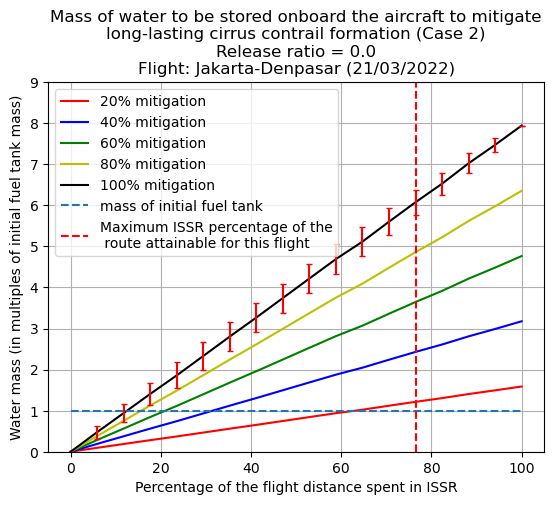

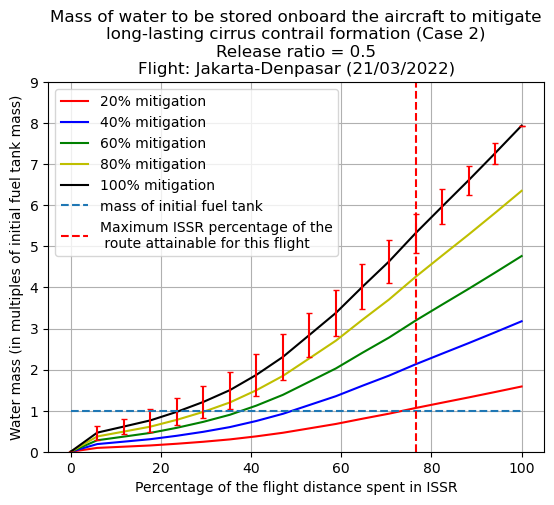

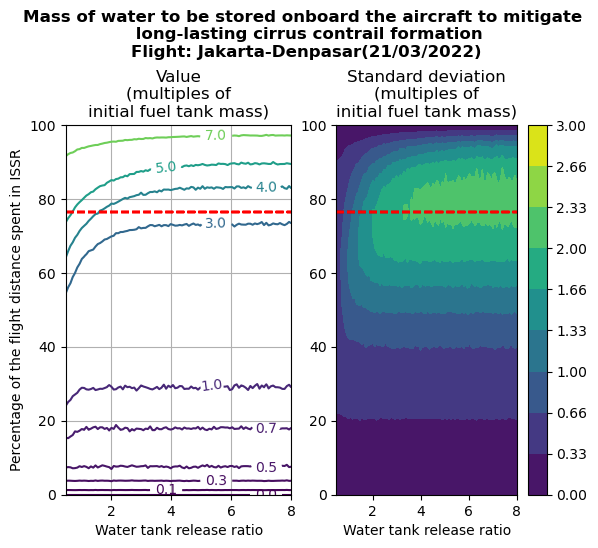

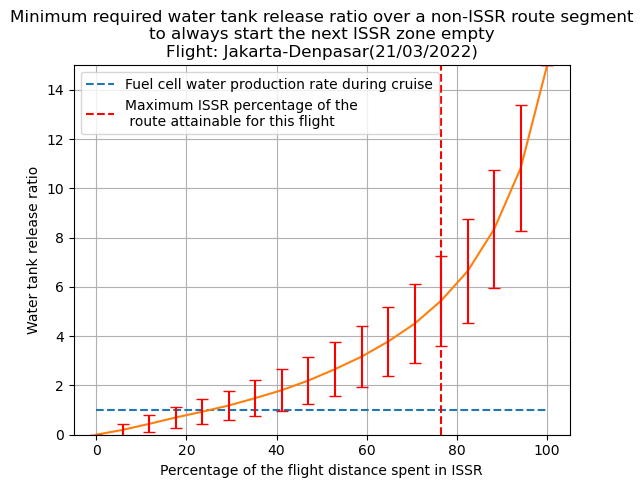

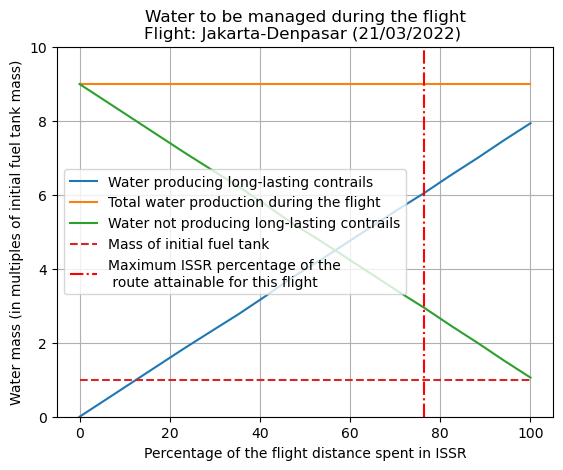

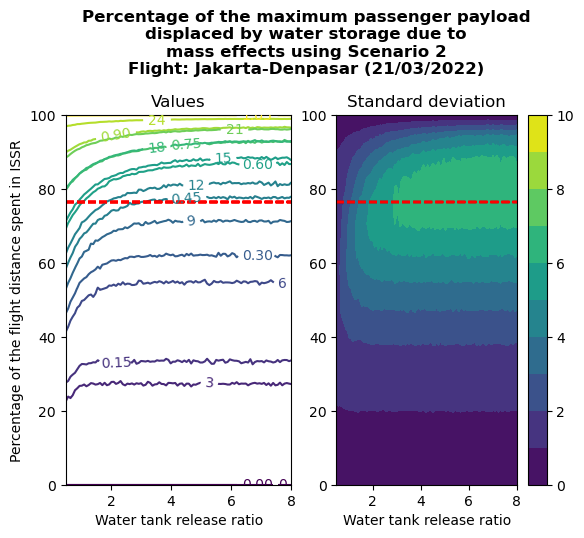

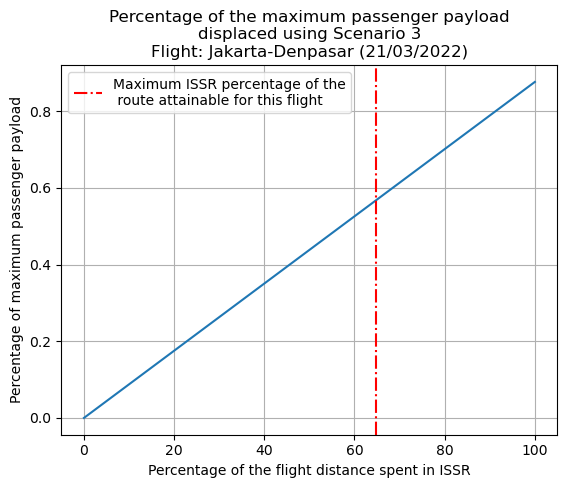

In [50]:
## Analysis for Jakarta - Denpasar : 21/03/2022


nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 30
cell_temp_bulletin1[1] = 29.7
cell_temp_bulletin1[2] = 29.8
cell_temp_bulletin1[3] = 28.7
cell_temp_bulletin1[4] = 27.5
cell_temp_bulletin1[5] =28.3
cell_temp_bulletin1[6] = 27.2
cell_temp_bulletin1[7] = 25.2
cell_temp_bulletin1[8] = 27.8
cell_temp_bulletin1[9] = 27.4
cell_temp_bulletin1[10] = 25.7
cell_temp_bulletin1[11] =23.6
cell_temp_bulletin1[12]= 22.5
cell_temp_bulletin1[13] =24.7
cell_temp_bulletin1[14] = 24.4
cell_temp_bulletin1[15] = 25.6
cell_temp_bulletin1[16] = 25.7


cell_temp_bulletin2[0] = 27.8
cell_temp_bulletin2[1] =27.8
cell_temp_bulletin2[2] = 28.2
cell_temp_bulletin2[3] = 26
cell_temp_bulletin2[4] = 25.9
cell_temp_bulletin2[5] = 26.3
cell_temp_bulletin2[6] = 25.8
cell_temp_bulletin2[7] = 23.3
cell_temp_bulletin2[8] = 25
cell_temp_bulletin2[9] = 25.9
cell_temp_bulletin2[10] = 24.6
cell_temp_bulletin2[11] = 21.9
cell_temp_bulletin2[12]= 21.9
cell_temp_bulletin2[13] = 24.9
cell_temp_bulletin2[14] = 24.3
cell_temp_bulletin2[15] = 25.8
cell_temp_bulletin2[16] = 26.1

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/") # case 1

release_rate = 192*0.5
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/") # case 2 with a slow release rate

release_rate = 192*8
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/") # case 2 with a fast release rate

optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/") # Study the optimal release rate

case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/") # case 3

energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/")

passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/")

passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/")

#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/")

passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/03/2022", filedate = "21032022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21032022/")


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2669382650.py:186: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\1853534507.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  energ_H2[i] = 100/x


case2 [0.         0.02226433 0.05098026 0.08387074 0.13371248 0.16799449
 0.25705181 0.37254803 0.49829089 0.69993488 0.89145872 1.18317205
 1.50410731 1.82124752 2.16141106 2.50524316 2.85957492 3.21314766]
case 3 [0.         0.00737731 0.01434476 0.02123025 0.02909938 0.03606683
 0.04360808 0.05082145 0.05803481 0.06557606 0.0720517  0.08000279
 0.08787192 0.09426559 0.10229866 0.10869232 0.11565978 0.12295511]


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2098070579.py:185: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


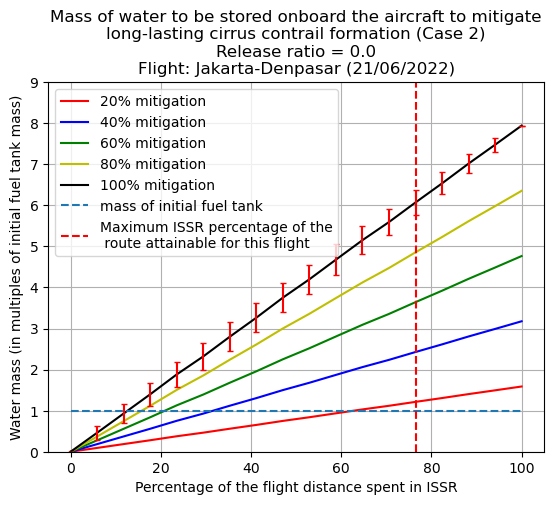

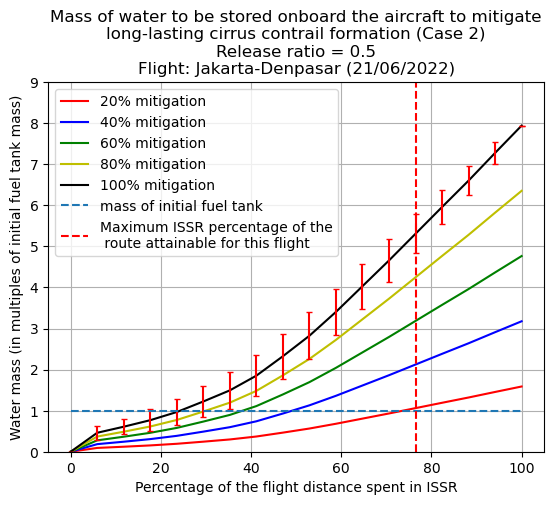

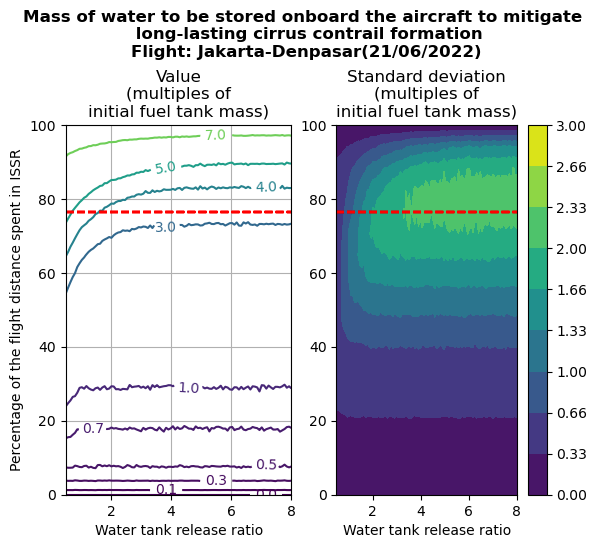

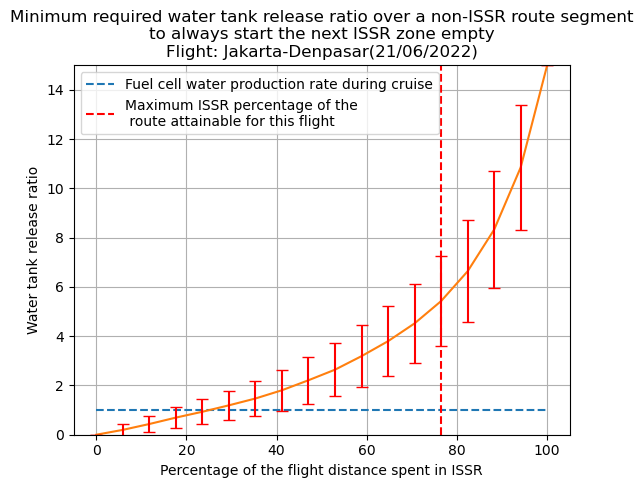

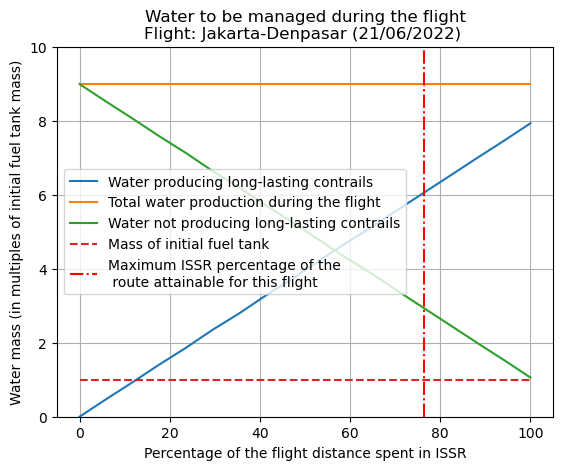

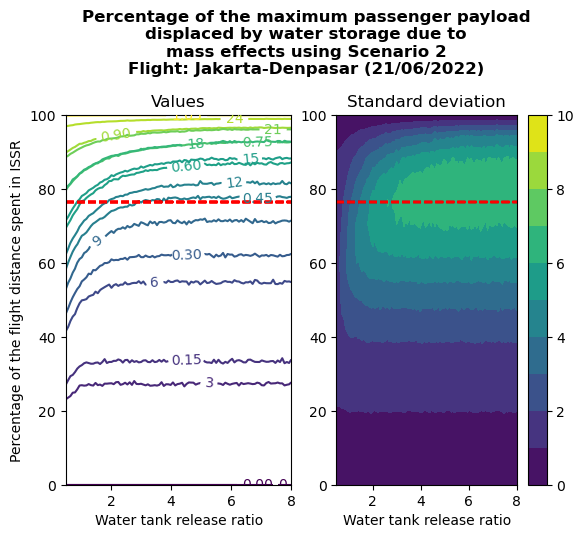

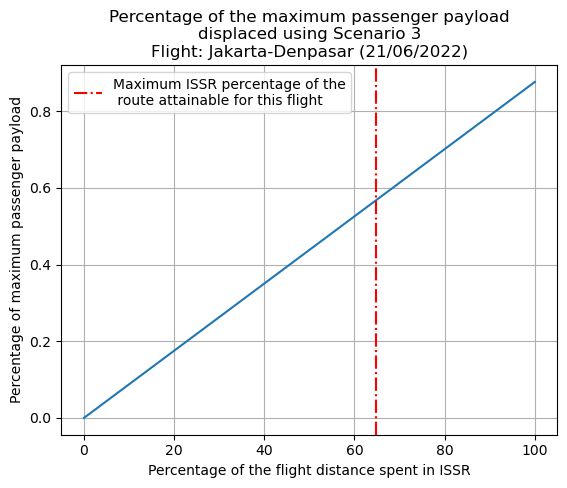

In [51]:
## Analysis for Jakarta - Denpasar : 21/06/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 29.7
cell_temp_bulletin1[1] =29.2
cell_temp_bulletin1[2] = 29.4
cell_temp_bulletin1[3] =28.6
cell_temp_bulletin1[4] = 28.2
cell_temp_bulletin1[5] =28.5
cell_temp_bulletin1[6] = 26.6
cell_temp_bulletin1[7] = 25.2
cell_temp_bulletin1[8] = 28.4
cell_temp_bulletin1[9] = 28.9
cell_temp_bulletin1[10] = 26.7
cell_temp_bulletin1[11] =24.3
cell_temp_bulletin1[12]= 23.6
cell_temp_bulletin1[13] =25.4
cell_temp_bulletin1[14] = 25.3
cell_temp_bulletin1[15] = 26.6
cell_temp_bulletin1[16] = 26.6


cell_temp_bulletin2[0] = 27.2
cell_temp_bulletin2[1] =26.7
cell_temp_bulletin2[2] = 26.8
cell_temp_bulletin2[3] = 25.6
cell_temp_bulletin2[4] = 26.1
cell_temp_bulletin2[5] = 26.8
cell_temp_bulletin2[6] = 25.2
cell_temp_bulletin2[7] = 22.9
cell_temp_bulletin2[8] = 26.4
cell_temp_bulletin2[9] = 26.7
cell_temp_bulletin2[10] = 25.4
cell_temp_bulletin2[11] = 21.9
cell_temp_bulletin2[12]= 21.7
cell_temp_bulletin2[13] = 24.1
cell_temp_bulletin2[14] = 24.3
cell_temp_bulletin2[15] = 26
cell_temp_bulletin2[16] = 25.9

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/") # case 1

release_rate = 192*0.5
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate,date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/") # case 2 with a slow release rate

release_rate = 192*8
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/") # case 2 with a fast release rate

optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/") # Study the optimal release rate

case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/") # case 3

energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/")

passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/")

passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/")

#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/")

passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/06/2022", filedate = "21062022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21062022/")



C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2669382650.py:186: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\1853534507.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  energ_H2[i] = 100/x


case2 [0.         0.02302334 0.04769121 0.08374424 0.1210623  0.18153019
 0.25566029 0.37419255 0.53775948 0.70056739 0.97798601 1.23111626
 1.48740906 1.88664899 2.05907104 2.49891807 2.82592542 3.21314766]
case 3 [0.         0.0071314  0.01467264 0.02147616 0.02893544 0.03606683
 0.04377202 0.05147721 0.05893648 0.06516621 0.0728714  0.07910112
 0.0865604  0.09377377 0.10147895 0.10811853 0.11590569 0.12295511]


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2098070579.py:185: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


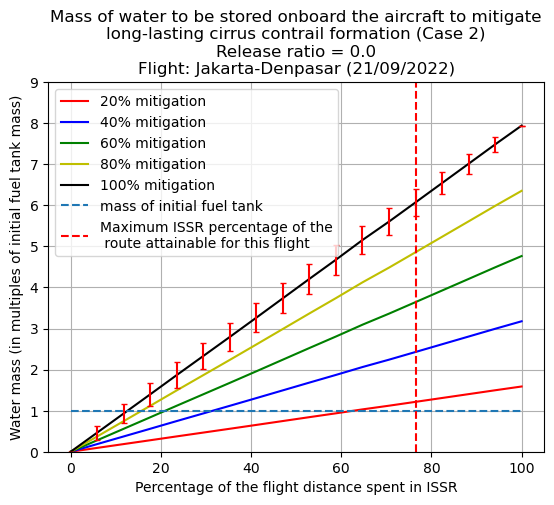

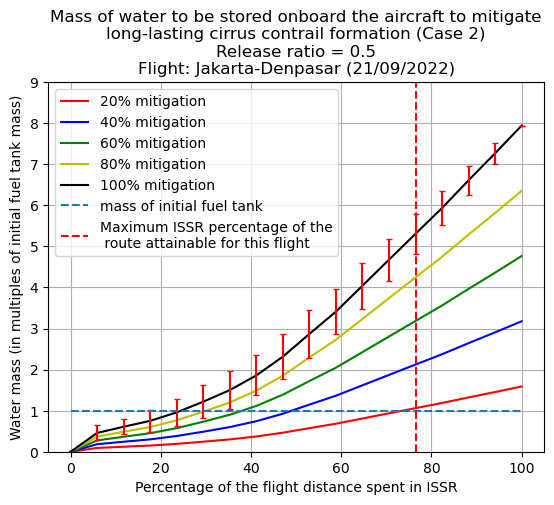

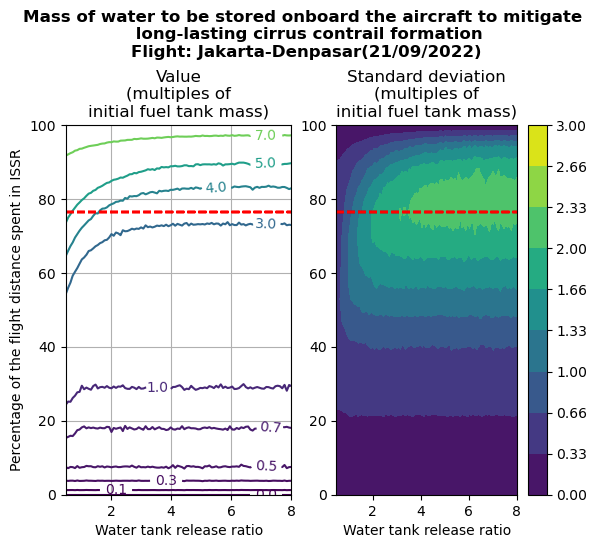

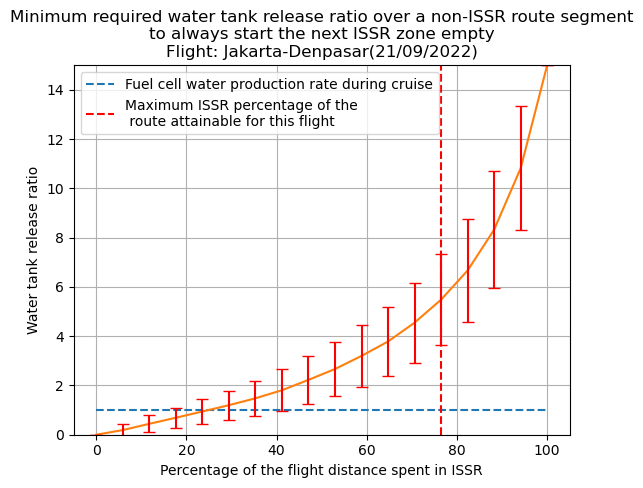

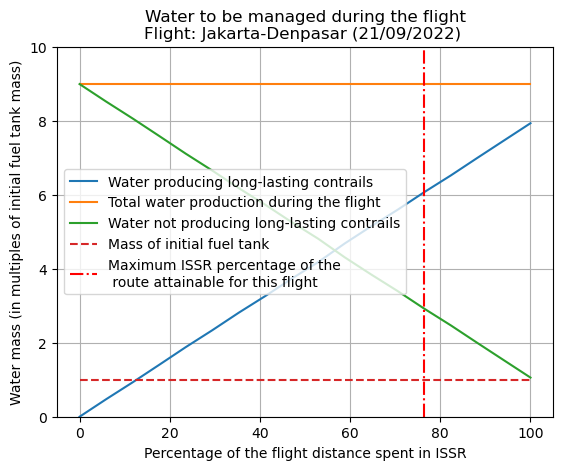

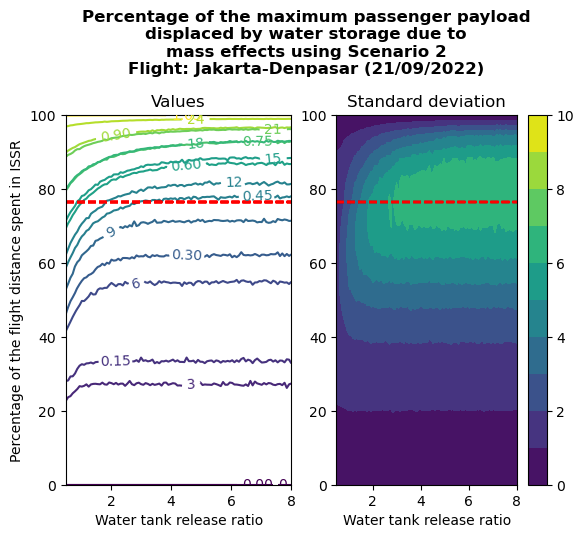

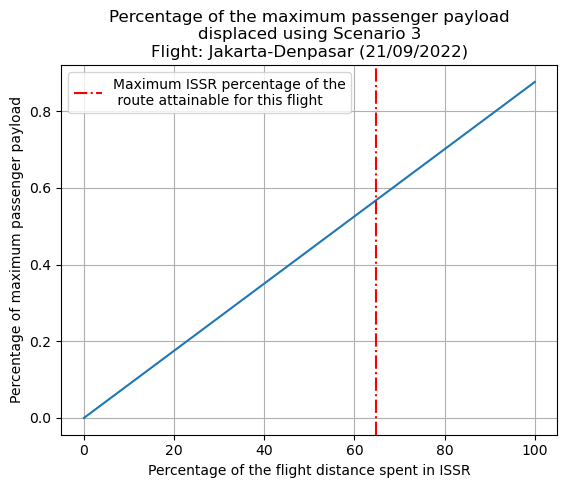

In [52]:
## Analysis for Jakarta - Denpasar : 21/09/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 29.6
cell_temp_bulletin1[1] =29.8
cell_temp_bulletin1[2] = 30.6
cell_temp_bulletin1[3] =30.3
cell_temp_bulletin1[4] = 27.8
cell_temp_bulletin1[5] =27.2
cell_temp_bulletin1[6] = 25
cell_temp_bulletin1[7] = 24.7
cell_temp_bulletin1[8] = 28.6
cell_temp_bulletin1[9] = 29
cell_temp_bulletin1[10] = 26
cell_temp_bulletin1[11] =23.5
cell_temp_bulletin1[12]= 22.5
cell_temp_bulletin1[13] =24.3
cell_temp_bulletin1[14] = 24.4
cell_temp_bulletin1[15] = 25.4
cell_temp_bulletin1[16] = 25.4


cell_temp_bulletin2[0] = 27.6
cell_temp_bulletin2[1] =27
cell_temp_bulletin2[2] = 27.8
cell_temp_bulletin2[3] = 27.5
cell_temp_bulletin2[4] = 26.3
cell_temp_bulletin2[5] = 26
cell_temp_bulletin2[6] = 24.5
cell_temp_bulletin2[7] = 23
cell_temp_bulletin2[8] = 25.4
cell_temp_bulletin2[9] = 26.8
cell_temp_bulletin2[10] = 24.8
cell_temp_bulletin2[11] = 21.9
cell_temp_bulletin2[12]= 21.1
cell_temp_bulletin2[13] = 23.8
cell_temp_bulletin2[14] = 23.4
cell_temp_bulletin2[15] = 25
cell_temp_bulletin2[16] = 25

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # case 1

release_rate = 192*0.5
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # case 2 with a slow release rate

release_rate = 192*8
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # case 2 with a fast release rate

optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # Study the optimal release rate

case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # case 3

energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/")

passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/")

passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/")

#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/")

passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/")



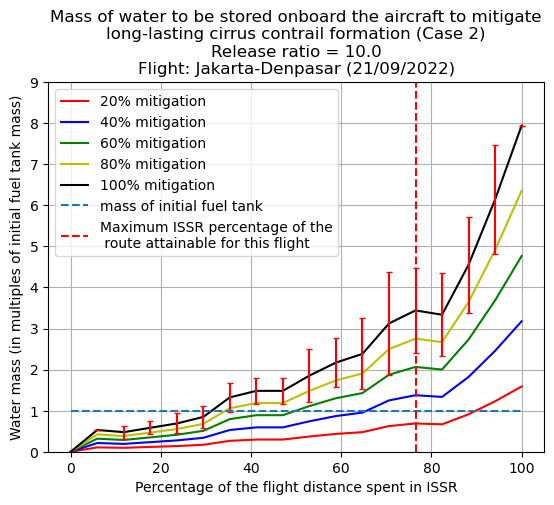

In [53]:
## test : 

release_rate = 192*10
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 10, release_rate, date = "21/09/2022", filedate = "21092022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21092022/") # case 2 with a slow release rate

C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2669382650.py:186: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\1853534507.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  energ_H2[i] = 100/x


case2 [0.         0.01948129 0.05161277 0.08361774 0.12928492 0.19013232
 0.25970835 0.36280738 0.52966336 0.70031439 0.96913088 1.21467102
 1.47931294 1.83933728 2.20391569 2.54079019 2.83073249 3.21314766]
case 3 [0.         0.00762322 0.01418082 0.02155813 0.02852559 0.03582092
 0.0432802  0.0512313  0.05729708 0.06549409 0.07237958 0.07967491
 0.08680631 0.09385574 0.10074122 0.10803656 0.11549584 0.12295511]


C:\Users\Gaétan\AppData\Local\Temp\ipykernel_21800\2098070579.py:185: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


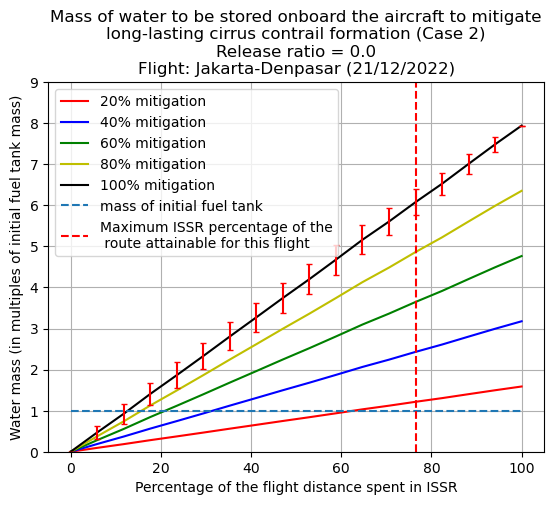

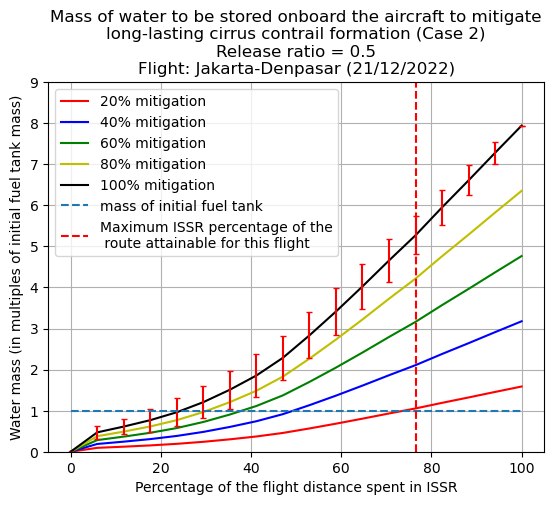

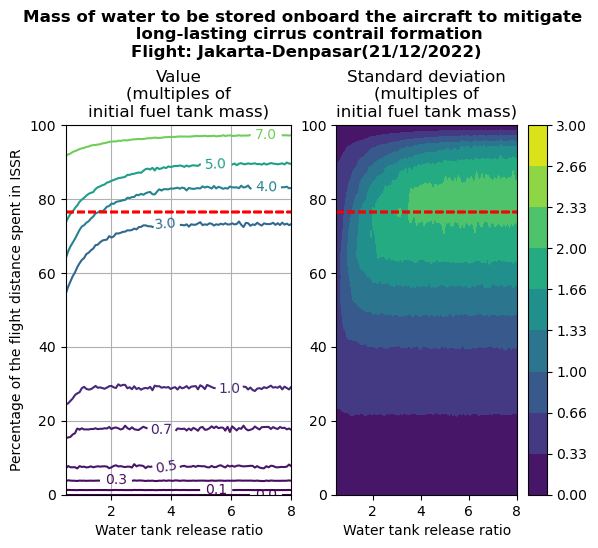

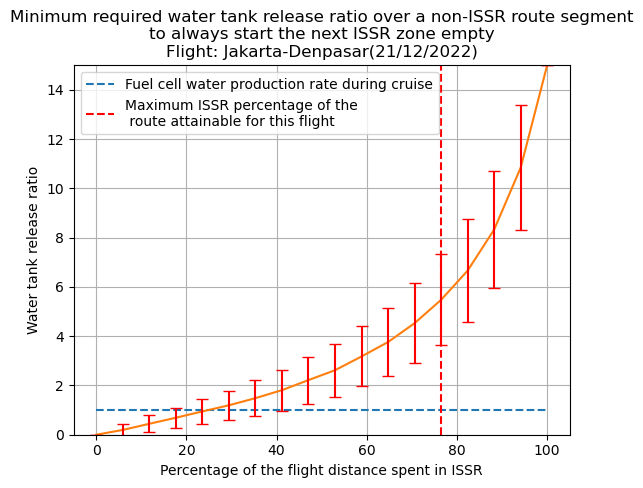

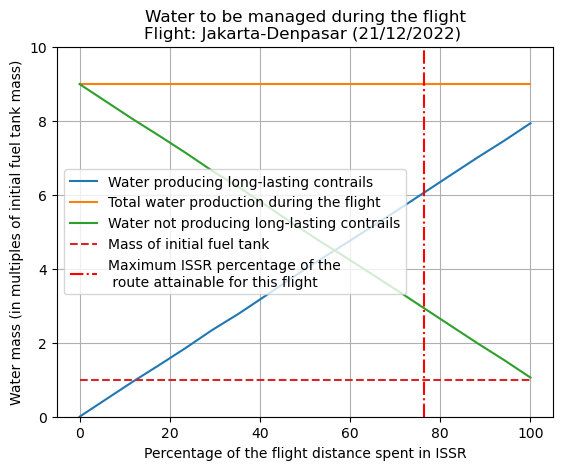

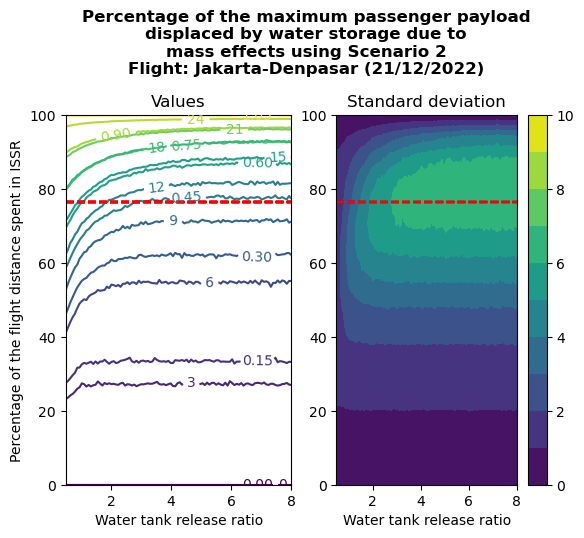

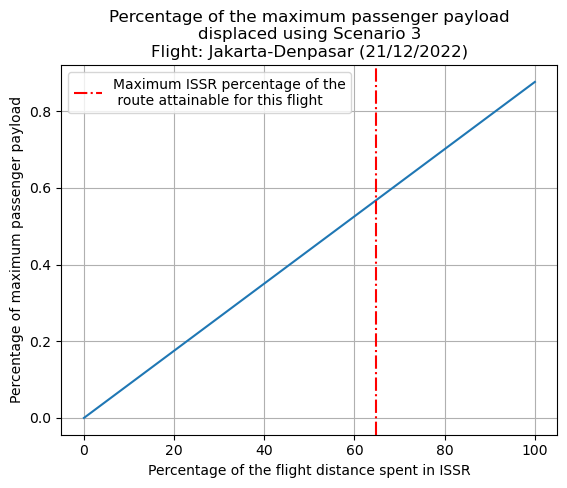

In [54]:
## Analysis for Jakarta - Denpasar : 21/12/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 29.1
cell_temp_bulletin1[1] =28.3
cell_temp_bulletin1[2] = 27.1
cell_temp_bulletin1[3] =25.4
cell_temp_bulletin1[4] = 25.6
cell_temp_bulletin1[5] =26.1
cell_temp_bulletin1[6] = 27.4
cell_temp_bulletin1[7] = 26
cell_temp_bulletin1[8] = 28.5
cell_temp_bulletin1[9] = 28.1
cell_temp_bulletin1[10] = 27.2
cell_temp_bulletin1[11] =23.9
cell_temp_bulletin1[12]= 24.6
cell_temp_bulletin1[13] =26.4
cell_temp_bulletin1[14] = 27.3
cell_temp_bulletin1[15] = 27.1
cell_temp_bulletin1[16] = 27


cell_temp_bulletin2[0] = 26.4
cell_temp_bulletin2[1] = 25.9
cell_temp_bulletin2[2] = 25.8
cell_temp_bulletin2[3] = 24.7
cell_temp_bulletin2[4] = 25.3
cell_temp_bulletin2[5] = 24.9
cell_temp_bulletin2[6] = 23.9
cell_temp_bulletin2[7] = 22
cell_temp_bulletin2[8] = 24.8
cell_temp_bulletin2[9] = 25.6
cell_temp_bulletin2[10] = 24.4
cell_temp_bulletin2[11] = 21.3
cell_temp_bulletin2[12]= 21.9
cell_temp_bulletin2[13] = 23.4
cell_temp_bulletin2[14] = 24.2
cell_temp_bulletin2[15] = 25.5
cell_temp_bulletin2[16] = 25.3

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/") # case 1

release_rate = 192*0.5
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/") # case 2 with a slow release rate

release_rate = 192*8
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/") # case 2 with a slow release rate

release_rates = np.linspace(96, 1536, 100)
case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/") # case 2 with a fast release rate

optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/") # Study the optimal release rate

case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/") # case 3

energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/") # comparison of the different cases put together

#energy_use_comp_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/")

passenger_cost_volume(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/")

passenger_cost_mass(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/")

#break_even(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/")

passenger_cost_mass3(bul1, bul2, bul_alt, flightdata, 100,date = "21/12/2022", filedate = "21122022", route = "Jakarta-Denpasar", path = "Graph_results/Jakarta-Denpasar/21122022/")



In [55]:
## Analysis for Longyearbyen - Mourmansk : 21/03/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = -4.4
cell_temp_bulletin1[1] = -6.5
cell_temp_bulletin1[2] = -4.5
cell_temp_bulletin1[3] = -1.7
cell_temp_bulletin1[4] = -1.5
cell_temp_bulletin1[5] = -1.7
cell_temp_bulletin1[6] = -0.4
cell_temp_bulletin1[7] = 0.3
cell_temp_bulletin1[8] = 0.5
cell_temp_bulletin1[9] = 1.2
cell_temp_bulletin1[10] = 1.5
cell_temp_bulletin1[11] = 2
cell_temp_bulletin1[12]= 2.8
cell_temp_bulletin1[13] = 3.1
cell_temp_bulletin1[14] = 3.6
cell_temp_bulletin1[15] = 5.3
cell_temp_bulletin1[16] = 7.4


cell_temp_bulletin2[0] = -4.5
cell_temp_bulletin2[1] = -6.8
cell_temp_bulletin2[2] = -5
cell_temp_bulletin2[3] = -2.1
cell_temp_bulletin2[4] = -1.6
cell_temp_bulletin2[5] = -1.3
cell_temp_bulletin2[6] = -0.8
cell_temp_bulletin2[7] = -0.6
cell_temp_bulletin2[8] = -0.3
cell_temp_bulletin2[9] = 0.5
cell_temp_bulletin2[10] = 1
cell_temp_bulletin2[11] = 1.2
cell_temp_bulletin2[12]= 1.8
cell_temp_bulletin2[13] = 2.2
cell_temp_bulletin2[14] = 2.4
cell_temp_bulletin2[15] = 2.9
cell_temp_bulletin2[16] = 4.3

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0) # case 1

#release_rate = 192*0.5
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rate = 192*8
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rates = np.linspace(96, 1536, 100)
#case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates) # case 2 with a fast release rate

#optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000) # Study the optimal release rate

#case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000) # case 3

#energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS) # comparison of the different cases put together

In [56]:
## Analysis for Longyearbyen - Mourmansk : 21/06/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 5.1
cell_temp_bulletin1[1] = 2.8
cell_temp_bulletin1[2] = 2.6
cell_temp_bulletin1[3] = 3.1
cell_temp_bulletin1[4] = 3.6
cell_temp_bulletin1[5] = 3.5
cell_temp_bulletin1[6] = 3.7
cell_temp_bulletin1[7] = 4.6
cell_temp_bulletin1[8] = 6
cell_temp_bulletin1[9] = 6.6
cell_temp_bulletin1[10] = 6.9
cell_temp_bulletin1[11] = 7.1
cell_temp_bulletin1[12]= 7.3
cell_temp_bulletin1[13] = 7.4
cell_temp_bulletin1[14] = 7.4
cell_temp_bulletin1[15] = 11.9
cell_temp_bulletin1[16] = 16.1


cell_temp_bulletin2[0] = 4.7
cell_temp_bulletin2[1] = 2.5
cell_temp_bulletin2[2] = 2.3
cell_temp_bulletin2[3] = 2.9
cell_temp_bulletin2[4] = 3.3
cell_temp_bulletin2[5] = 3.3
cell_temp_bulletin2[6] = 3.5
cell_temp_bulletin2[7] = 4.5
cell_temp_bulletin2[8] = 6.1
cell_temp_bulletin2[9] = 6.7
cell_temp_bulletin2[10] = 6.9
cell_temp_bulletin2[11] = 7.2
cell_temp_bulletin2[12] = 7.3
cell_temp_bulletin2[13] = 7.6
cell_temp_bulletin2[14] = 7.8
cell_temp_bulletin2[15] = 11.8
cell_temp_bulletin2[16] = 14.3

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0) # case 1

#release_rate = 192*0.5
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rate = 192*8
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rates = np.linspace(96, 1536, 100)
#case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates) # case 2 with a fast release rate

#optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000) # Study the optimal release rate

#case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000) # case 3

#energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS) # comparison of the different cases put together

In [57]:
## Analysis for Longyearbyen - Mourmansk : 21/09/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = 1.1
cell_temp_bulletin1[1] = -1.2
cell_temp_bulletin1[2] = 0
cell_temp_bulletin1[3] = 2.2
cell_temp_bulletin1[4] = 2.6
cell_temp_bulletin1[5] = 3.1
cell_temp_bulletin1[6] = 3.2
cell_temp_bulletin1[7] = 3.3
cell_temp_bulletin1[8] = 4.4
cell_temp_bulletin1[9] = 5.1
cell_temp_bulletin1[10] = 6
cell_temp_bulletin1[11] = 7.8
cell_temp_bulletin1[12]= 7.9
cell_temp_bulletin1[13] = 7.7
cell_temp_bulletin1[14] = 7.4
cell_temp_bulletin1[15] = 6.8
cell_temp_bulletin1[16] = 6.3


cell_temp_bulletin2[0] = 0.4
cell_temp_bulletin2[1] = -1.5
cell_temp_bulletin2[2] = -0.4
cell_temp_bulletin2[3] = 1.9
cell_temp_bulletin2[4] = 2.6
cell_temp_bulletin2[5] = 3.2
cell_temp_bulletin2[6] = 3.5
cell_temp_bulletin2[7] = 3.5
cell_temp_bulletin2[8] = 4.2
cell_temp_bulletin2[9] = 5.3
cell_temp_bulletin2[10] = 6.8
cell_temp_bulletin2[11] = 7.8
cell_temp_bulletin2[12] = 8.4
cell_temp_bulletin2[13] = 8.3
cell_temp_bulletin2[14] = 7.6
cell_temp_bulletin2[15] = 7
cell_temp_bulletin2[16] = 5.7

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0) # case 1

#release_rate = 192*0.5
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rate = 192*8
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rates = np.linspace(96, 1536, 100)
#case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates) # case 2 with a fast release rate

#optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000) # Study the optimal release rate

#case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000) # case 3

#energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS) # comparison of the different cases put together

In [58]:
## Analysis for Longyearbyen - Mourmansk : 21/12/2022

nb_point=17 # granularity of the temperature profile
cell_temp_bulletin1 = np.zeros(nb_point)
cell_temp_bulletin2 = np.zeros(nb_point)

# Temperature values for a flight taking off Friday the 26th of May 2023 from Paris, data from Copernicus (https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form ), exploited using XyGrib (https://opengribs.org/fr/ ) : 

cell_temp_bulletin1[0] = -13.4
cell_temp_bulletin1[1] = -16.3
cell_temp_bulletin1[2] = -12.2
cell_temp_bulletin1[3] = -5.2
cell_temp_bulletin1[4] = -4
cell_temp_bulletin1[5] = -3
cell_temp_bulletin1[6] = -2.2
cell_temp_bulletin1[7] = -0.6
cell_temp_bulletin1[8] = 0.1
cell_temp_bulletin1[9] = 0.6
cell_temp_bulletin1[10] = 0.8
cell_temp_bulletin1[11] = 1
cell_temp_bulletin1[12] = 0.8
cell_temp_bulletin1[13] = 0.7
cell_temp_bulletin1[14] = 0.1
cell_temp_bulletin1[15] = -2.5
cell_temp_bulletin1[16] = -5.6


cell_temp_bulletin2[0] = -13.2
cell_temp_bulletin2[1] = -15.5
cell_temp_bulletin2[2] = -12.3
cell_temp_bulletin2[3] = -5
cell_temp_bulletin2[4] = -3.3
cell_temp_bulletin2[5] = -0.8
cell_temp_bulletin2[6] = -0.4
cell_temp_bulletin2[7] = -0.2
cell_temp_bulletin2[8] = 0.3
cell_temp_bulletin2[9] = 0.7
cell_temp_bulletin2[10] = 0.9
cell_temp_bulletin2[11] = 1
cell_temp_bulletin2[12] = 0.9
cell_temp_bulletin2[13] = 0.7
cell_temp_bulletin2[14] = 0.1
cell_temp_bulletin2[15] = -2.9
cell_temp_bulletin2[16] = -7

# Altitudes at which the temperatures are measured along the pathway of the aircraft on the ground trace.

cell_altitude_bulletin = np.zeros(nb_point)  # in hPa

cell_altitude_bulletin[0] = 1004
cell_altitude_bulletin[1] = 1004
cell_altitude_bulletin[2] = 1004
cell_altitude_bulletin[3] = 1004
cell_altitude_bulletin[4] = 1004
cell_altitude_bulletin[5] = 1004
cell_altitude_bulletin[6] = 1004
cell_altitude_bulletin[7] = 1005
cell_altitude_bulletin[9] = 1005
cell_altitude_bulletin[10] = 1005
cell_altitude_bulletin[11] = 1006
cell_altitude_bulletin[12]= 1006
cell_altitude_bulletin[13] =1006
cell_altitude_bulletin[14] =1007
cell_altitude_bulletin[15] = 1007
cell_altitude_bulletin[16] = 1007


bul1_BS = cell_temp_bulletin1
bul2_BS = cell_temp_bulletin2
bul_alt_BS = 1013.25 * np.ones(len(bul1))

flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

## analysis


#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, 0) # case 1

#release_rate = 192*0.5
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rate = 192*8
#case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rate) # case 2 with a slow release rate

#release_rates = np.linspace(96, 1536, 100)
#case2_sensitivity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1000, release_rates) # case 2 with a fast release rate

#optimal_release_averaged(bul1_BS,bul2_BS,bul_alt_BS, flightdata_BS,10000) # Study the optimal release rate

#case3_pumped_quantity(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS,1000) # case 3

#energy_use_comp(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS) # comparison of the different cases put together

FileNotFoundError: [Errno 2] No such file or directory: 'hey/hoy/trial1.png'

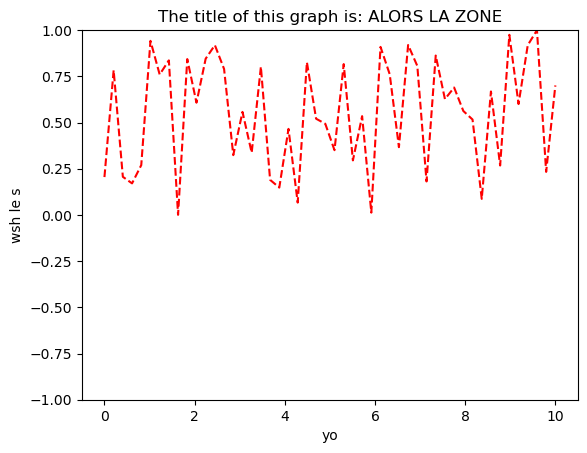

In [59]:
## test of different functions: 

def trial_function(stro):

    x1 = np.linspace(0,10)
    x2 = np.random.rand(1, len(x1))

    fig, ax = plt.subplots()
    ax.plot(x1,x2[0], linestyle = '--', color = 'r')
    ax.set_ylim(-1,1)

    title = "The title of this graph is: " +  stro
    plt.title(title)
    plt.xlabel('yo')
    plt.ylabel('wsh le s')
    plt.savefig("hey/hoy/trial1.png")

trial_function("ALORS LA ZONE")
trial_function("nikoumouk")

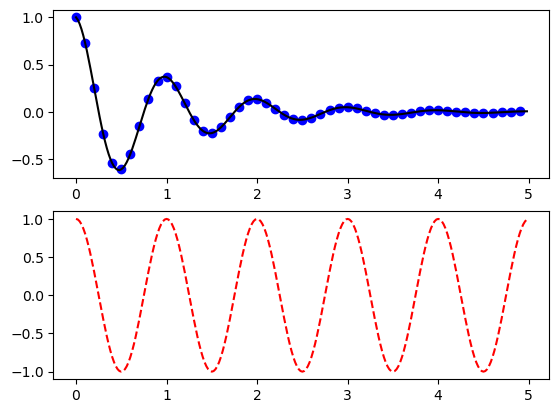

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

fig, axs = plt.subplots(2, 1)

axs[0].plot(t1, f(t1), "bo")
axs[0].plot(t2, f(t2), "k")

axs[1].plot(t2, np.cos(2*np.pi*t2), "r--")

plt.show()

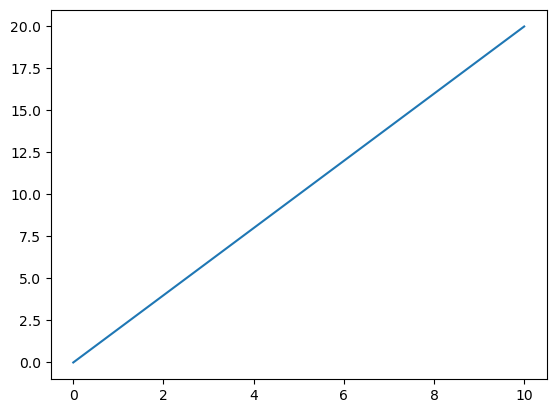

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
y = 2*x

fig, ax = plt.subplots()
ax.plot(x, y)
#ax.set_ylim(-1, 1)
plt.show()

There is  0.0  % of the flight producing contrails.
The contrail profile along the route is printed below and returned by this function.
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

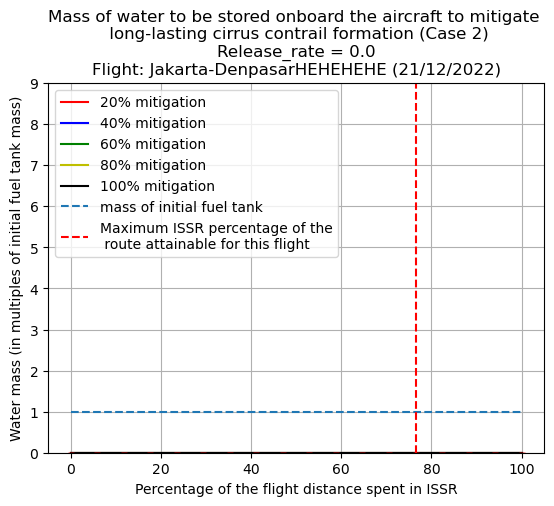

In [ ]:
bul1 = 69.5*np.ones(17)
bul1_BS = bul1
bul2_BS = bul1
bul_alt = np.ones(17)*1013.25
flightdata_BS = flightplan_ideal(len(bul1), bul_alt, 585)

release_rate = 192*0
case2_average(bul1_BS, bul2_BS, bul_alt_BS, flightdata_BS, 1, release_rate, date = "21/12/2022", filedate = "21122022", route = "Jakarta-DenpasarHEHEHEHE", path = "") # case 2 with a slow release rate

contrail_profile(bul1, bul1, bul_alt, flightdata_BS)